## PURPOSE OF THE NOTEBOOK
The aim of this notebook is to define vessels present in the GB sections and define size, structure and composition of them

# Import all libraries & functions needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import scanpy as sc
import os 
import seaborn as sns
import networkx as nx
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
import scipy.stats as scpst

In [2]:
def connected_components(neighbors):
    seen = set()
    def component(node):
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            seen.add(node)
            nodes |= neighbors[node] - seen
            yield node
    for node in neighbors:
        if node not in seen:
            yield component(node)
def getRoots(aNeigh):
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            try:
                (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
                (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
                if myRoot_myI != myRoot_myJ: 
                    myMin = myRoot_myI
                    myMax = myRoot_myJ 
                    if  myDepthMyI > myDepthMyJ: 
                        myMin = myRoot_myJ
                        myMax = myRoot_myI
                    myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                    myRoot[myMin] = (myRoot[myMax][0],-1) 
            except:
                sss=2
    myToRet = {}
    for myI in aNeigh: 
        if myRoot[myI][0] == myI:
            myToRet[myI] = []
    for myI in aNeigh: 
        myToRet[findRoot(myI,myRoot)[0]].append(myI) 
    return myToRet  

# first we load the dataset

In [3]:
def define_basal_apical(path,reg,memb):
    EPI=pd.read_csv(path+reg)
    json_feat=pd.read_json(path+memb)
    coords=pd.DataFrame(json_feat['features'][0]['geometry']['coordinates'][0][0])
    coords.columns=['x','y']
    plt.scatter(EPI['xc'],EPI['yc'])
    plt.scatter(coords['x'],coords['y'])
    from tqdm import tqdm
    allp=[]
    for e in tqdm(EPI.index):
        xp=EPI.loc[e,'xc']
        yp=EPI.loc[e,'yc']
        meas=((coords['x']-xp)**2)+((coords['y']-yp)**2)
        allp.append(meas.min())
    EPI['basal_dist']=np.sqrt(allp)
    #EPI['basal_dist']=EPI['basal_dist'].round(-1)
    maxpc=np.percentile(EPI['basal_dist'],95)
    EPI['basal_dist'][EPI['basal_dist']>maxpc]=maxpc
    EPI['basal_dist']=EPI['basal_dist']/maxpc
    EPI['basal_dist_norm']=EPI['basal_dist'].round(1)
    plt.scatter(EPI['xc'],EPI['yc'],c=EPI['basal_dist'],s=1)
    exp=pd.crosstab(EPI['target'],EPI['basal_dist_norm'])
    #REMOVE THIS LINE TO NOT NORMALIZE BY THE SIZE OF THE EPITHELIUM
    return exp,EPI

100%|█████████████████████████████████████████████████████████████████████████| 121881/121881 [00:45<00:00, 2695.40it/s]


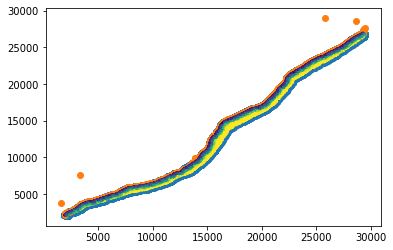

In [4]:
path='/mnt/f/ISS/epithelial_region/'
reg='640C_LNG2_epithelium.csv'
memb='640C_LNG2_basal_membrane.json'
exp640C_LNG2,EPI640C_LNG2=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

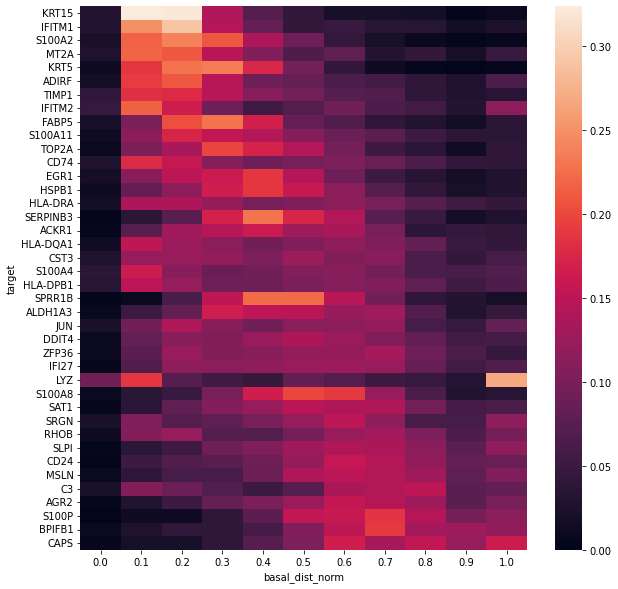

In [5]:
gorder=EPI640C_LNG2.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp640C_LNG2.loc[gorder,:]
selg=EPI640C_LNG2.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_640C_LNG2=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_640C_LNG2)

100%|███████████████████████████████████████████████████████████████████████████| 62592/62592 [00:24<00:00, 2562.28it/s]


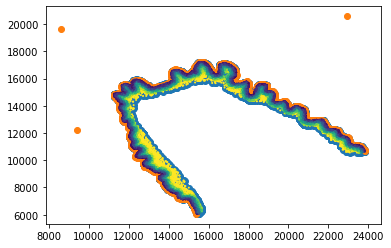

In [6]:
path='/mnt/f/ISS/epithelial_region/'
reg='640C_LNG3_epithelium.csv'
memb='640C_LNG3_basal_membrane..json'
exp640C_LNG3,EPI640C_LNG3=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

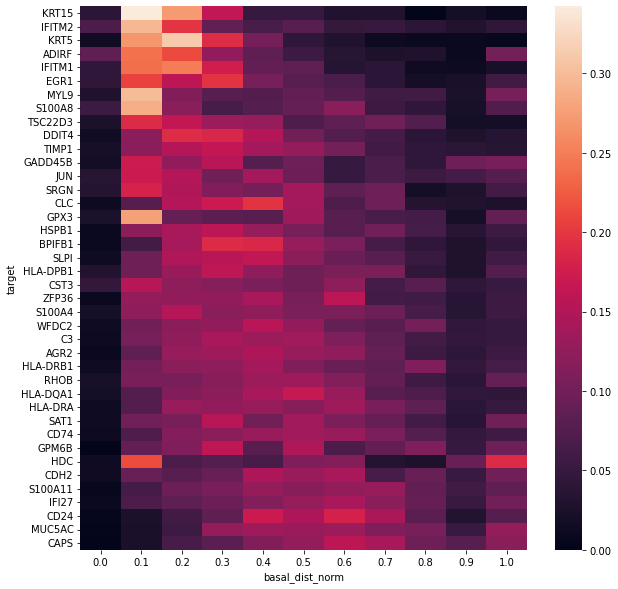

In [7]:
gorder=EPI640C_LNG3.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp640C_LNG3.loc[gorder,:]
selg=EPI640C_LNG3.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_640C_LNG3=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_640C_LNG3)

100%|███████████████████████████████████████████████████████████████████████████| 14351/14351 [00:05<00:00, 2776.15it/s]


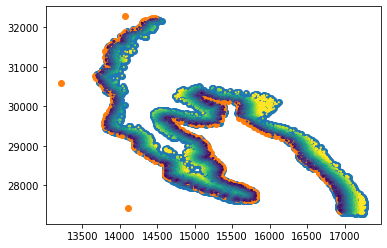

In [8]:
path='/mnt/f/ISS/epithelial_region/'
reg='640C_LNG5_epithelium.csv'
memb='640C_LNG5_basal_membrane..json'
exp640C_LNG5,EPI640C_LNG5=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

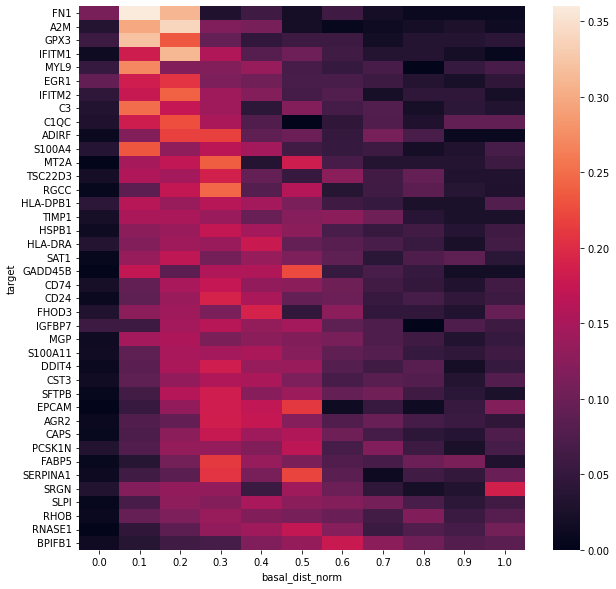

In [9]:
gorder=EPI640C_LNG5.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp640C_LNG5.loc[gorder,:]
selg=EPI640C_LNG5.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_640C_LNG5=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_640C_LNG5)

100%|███████████████████████████████████████████████████████████████████████████| 93568/93568 [00:37<00:00, 2526.19it/s]


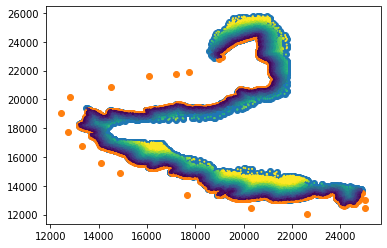

In [10]:
path='/mnt/f/ISS/epithelial_region/'
reg='583_LNG2_epithelium..csv'
memb='583_LNG2_basal_membrane..json'
exp583_LNG2,EPI583_LNG2=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

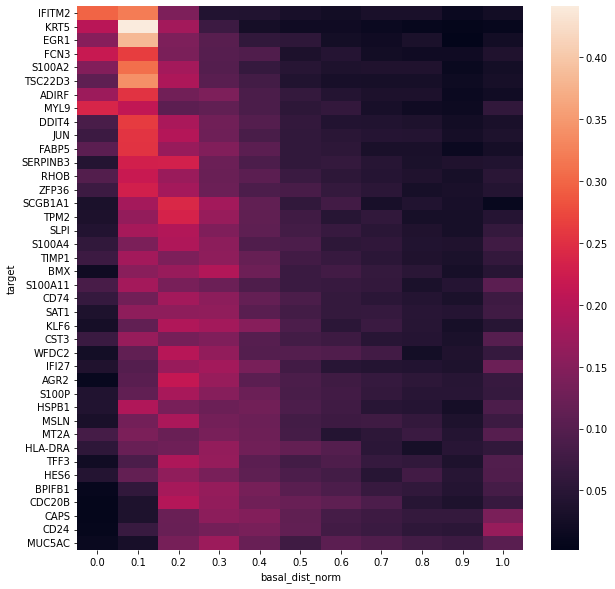

In [11]:
gorder=EPI583_LNG2.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp583_LNG2.loc[gorder,:]
selg=EPI583_LNG2.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_583_LNG2=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_583_LNG2)

100%|█████████████████████████████████████████████████████████████████████████████| 5706/5706 [00:02<00:00, 2707.90it/s]


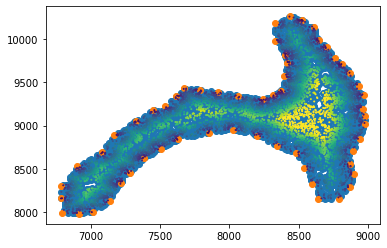

In [12]:
path='/mnt/f/ISS/epithelial_region/'
reg='588_LNG1_epithelium.csv'
memb='588_LNG1_basal_membrane..json'
exp588_LNG1,EPI588_LNG1=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

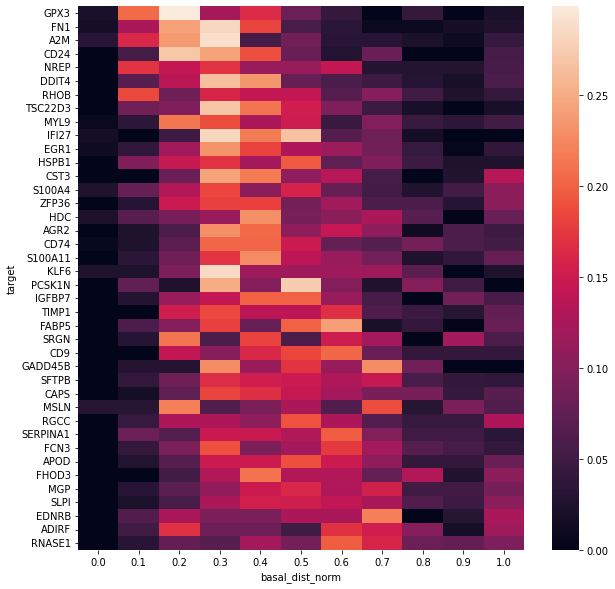

In [13]:
gorder=EPI588_LNG1.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp588_LNG1.loc[gorder,:]
selg=EPI588_LNG1.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_588_LNG1=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_588_LNG1)

100%|███████████████████████████████████████████████████████████████████████████| 32399/32399 [00:12<00:00, 2617.00it/s]


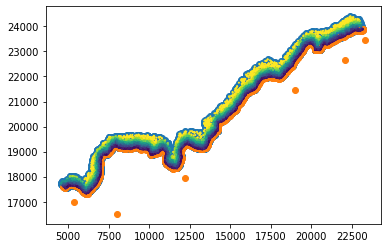

In [14]:
path='/mnt/f/ISS/epithelial_region/'
reg='588_LNG2_epithelium..csv'
memb='588_LNG2_basal_membrane..json'
exp588_LNG2,EPI588_LNG2=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

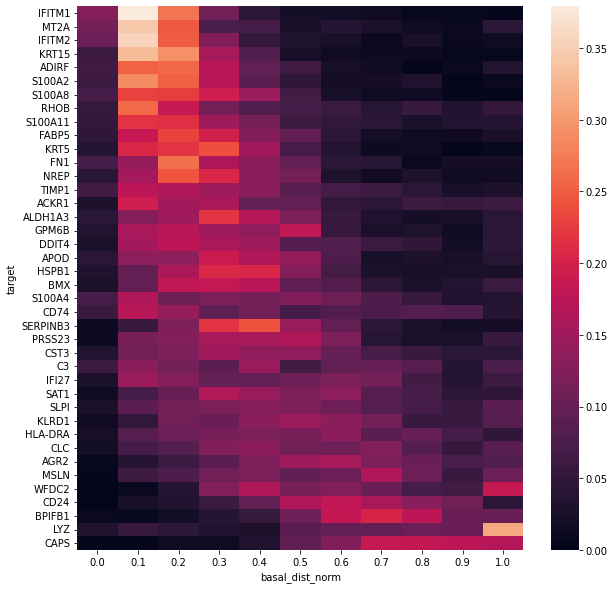

In [15]:
gorder=EPI588_LNG2.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp588_LNG2.loc[gorder,:]
selg=EPI588_LNG2.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_588_LNG2=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_588_LNG2)

100%|█████████████████████████████████████████████████████████████████████████████| 6555/6555 [00:02<00:00, 2730.07it/s]


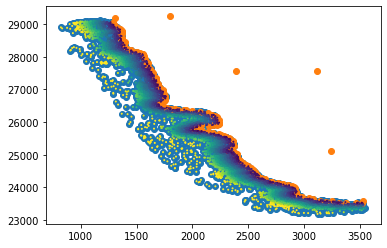

In [16]:
path='/mnt/f/ISS/epithelial_region/'
reg='588_LNG3_epithelium..csv'
memb='588_LNG3_basal_membrane..json'
exp588_LNG3,EPI588_LNG3=define_basal_apical(path,reg,memb)

<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

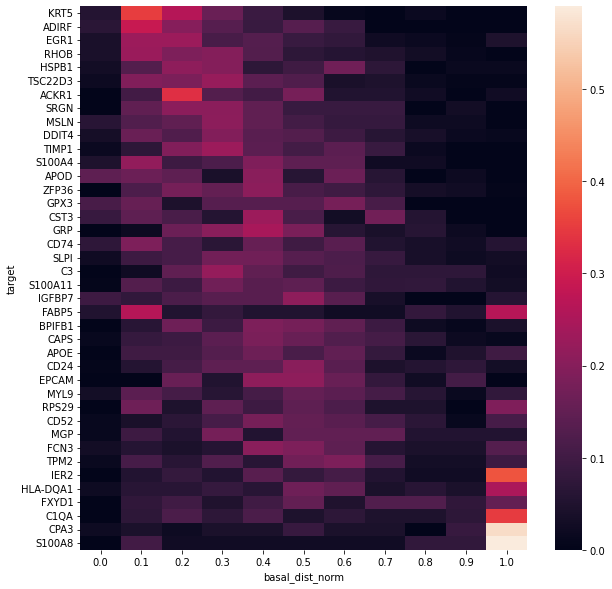

In [17]:
gorder=EPI588_LNG3.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp588_LNG3.loc[gorder,:]
selg=EPI588_LNG3.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_588_LNG3=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_588_LNG3)

100%|█████████████████████████████████████████████████████████████████████████████| 7405/7405 [00:02<00:00, 2776.62it/s]


<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

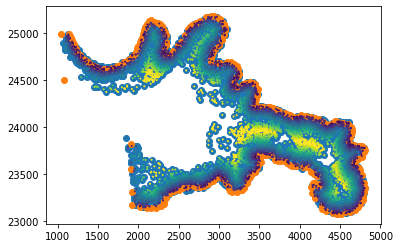

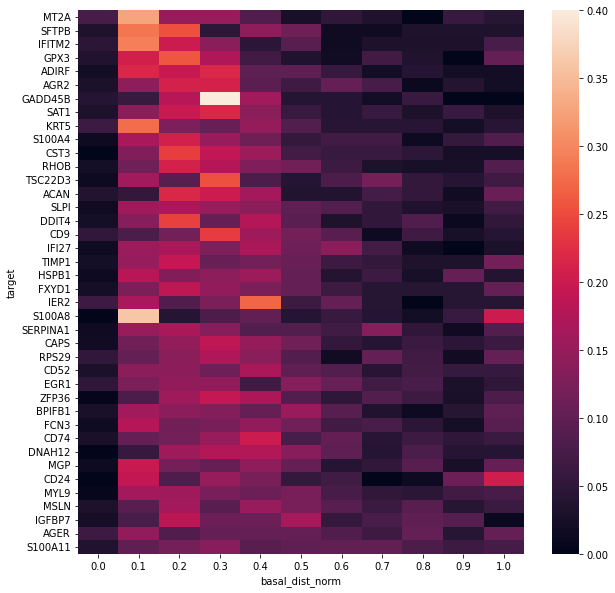

In [18]:
path='/mnt/f/ISS/epithelial_region/'
reg='588_LNG6_epithelium..csv'
memb='588_LNG6_basal_membrane..json'
exp588_LNG6,EPI588_LNG6=define_basal_apical(path,reg,memb)
gorder=EPI588_LNG6.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp588_LNG6.loc[gorder,:]
selg=EPI588_LNG6.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_588_LNG6=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_588_LNG6)

100%|█████████████████████████████████████████████████████████████████████████████| 7527/7527 [00:02<00:00, 2737.39it/s]


<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

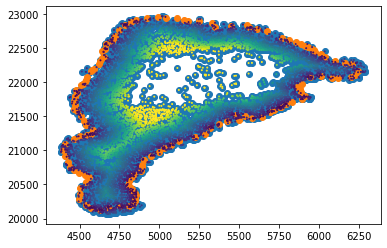

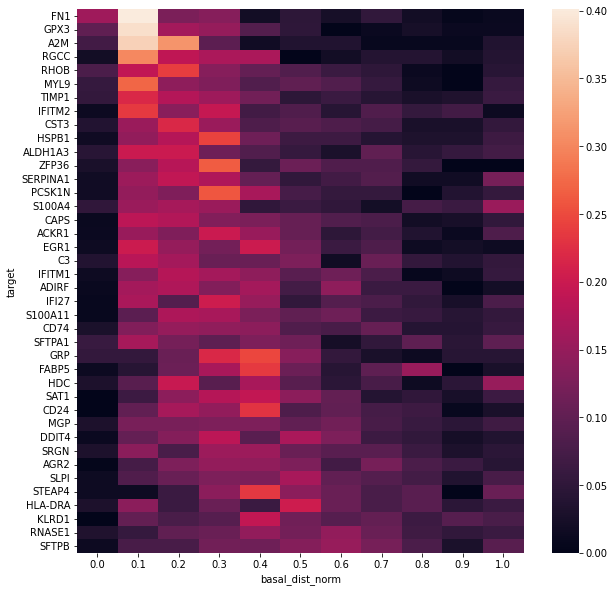

In [19]:
path='/mnt/f/ISS/epithelial_region/'
reg='689_LNG1_epithelium..csv'
memb='689_LNG1_basal_membrane..json'
exp689_LNG1,EPI689_LNG1=define_basal_apical(path,reg,memb)
gorder=EPI689_LNG1.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp689_LNG1.loc[gorder,:]
selg=EPI689_LNG1.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_689_LNG1=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_689_LNG1)



100%|███████████████████████████████████████████████████████████████████████████| 88166/88166 [00:35<00:00, 2493.89it/s]


<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

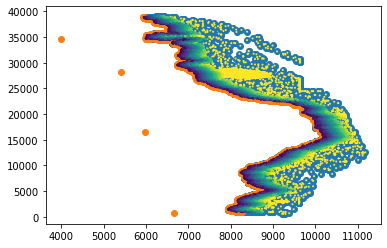

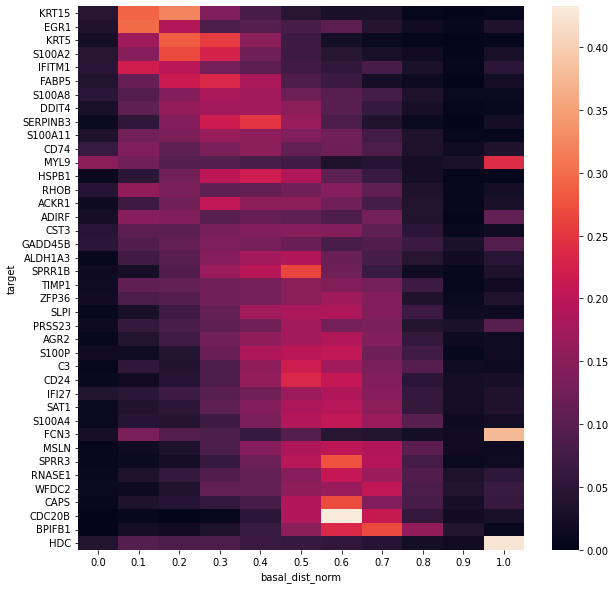

In [20]:
path='/mnt/f/ISS/epithelial_region/'
reg='689_LNG2_epithelium..csv'
memb='689_LNG2_basal_membrane..json'
exp689_LNG2,EPI689_LNG2=define_basal_apical(path,reg,memb)
gorder=EPI689_LNG2.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp689_LNG2.loc[gorder,:]
selg=EPI689_LNG2.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_689_LNG2=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_689_LNG2)



100%|█████████████████████████████████████████████████████████████████████████████| 3767/3767 [00:01<00:00, 2804.38it/s]


<AxesSubplot:xlabel='basal_dist_norm', ylabel='target'>

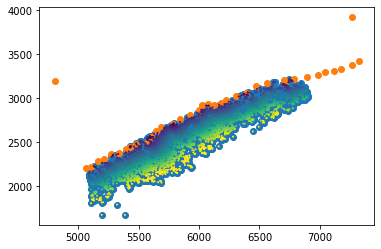

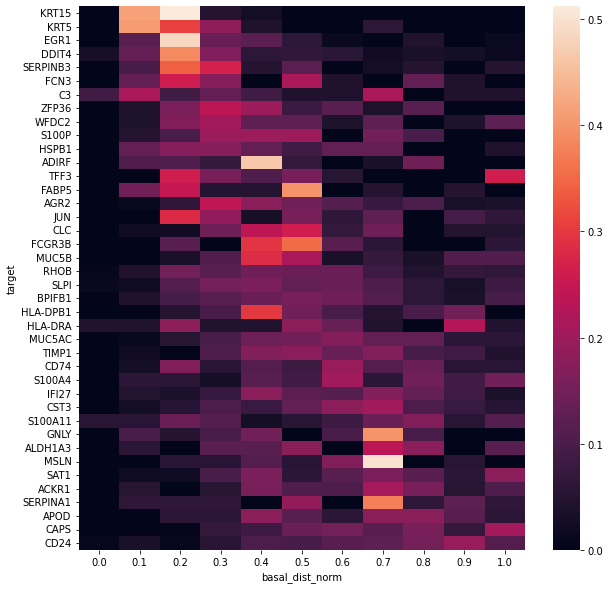

In [21]:
path='/mnt/f/ISS/epithelial_region/'
reg='689_LNG3_epithelium..csv'
memb='689_LNG3_basal_membrane..json'
exp689_LNG3,EPI689_LNG3=define_basal_apical(path,reg,memb)
gorder=EPI689_LNG3.loc[:,['target','basal_dist']].groupby('target').median().sort_values(by='basal_dist',ascending=True).index
exp=exp689_LNG3.loc[gorder,:]
selg=EPI689_LNG3.loc[:,['target','basal_dist']].groupby('target').count().sort_values(by='basal_dist',ascending=False)
expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]
expsort_689_LNG3=expsort.div(np.sum(expsort,axis=1),axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(expsort_689_LNG3)



# Comparing by global frequency

In [39]:
#640
counts640_LNG2=pd.DataFrame(np.sum(exp640C_LNG2,axis=1),columns=['640C_LNG2'])
counts640_LNG5=pd.DataFrame(np.sum(exp640C_LNG5,axis=1),columns=['640C_LNG5'])
counts640_LNG3=pd.DataFrame(np.sum(exp640C_LNG3,axis=1),columns=['640C_LNG3'])
#689
counts689_LNG2=pd.DataFrame(np.sum(exp689_LNG2,axis=1),columns=['689C_LNG2'])
counts689_LNG1=pd.DataFrame(np.sum(exp689_LNG1,axis=1),columns=['689C_LNG1'])
counts689_LNG3=pd.DataFrame(np.sum(exp689_LNG3,axis=1),columns=['689C_LNG3'])

#588
counts588_LNG2=pd.DataFrame(np.sum(exp588_LNG2,axis=1),columns=['588_LNG2'])
counts588_LNG1=pd.DataFrame(np.sum(exp588_LNG1,axis=1),columns=['588_LNG1'])
counts588_LNG3=pd.DataFrame(np.sum(exp588_LNG3,axis=1),columns=['588_LNG3'])


In [40]:
epith_expression=pd.concat([counts640_LNG2,counts640_LNG3,counts640_LNG5,counts689_LNG1,counts689_LNG2,counts689_LNG3,
                           counts588_LNG1,counts588_LNG2,counts588_LNG3],axis=1)

In [41]:
epith_expression=epith_expression.fillna(0)
exx=epith_expression.div(np.sum(epith_expression,axis=0),axis=1)
exxp=exx[exx.max(axis=1)>0.005]

<Figure size 720x720 with 0 Axes>

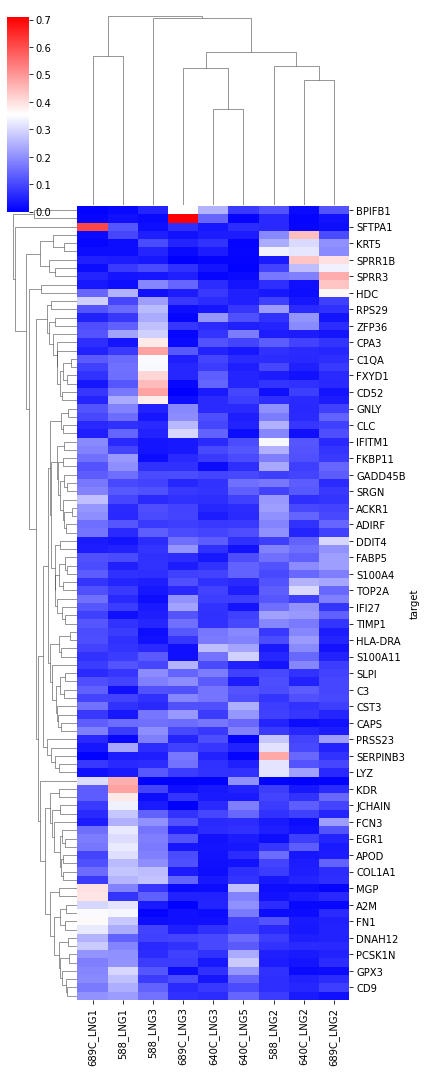

In [25]:
plt.figure(figsize=(10,10))
sns.clustermap(exxp.div(exxp.sum(axis=1),axis=0),figsize=(6,15),cmap='bwr')

# Comparison by structure

In [26]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [27]:
#640
counts640_LNG2=pd.DataFrame(np.std(exp640C_LNG2,axis=1),columns=['640C_LNG2'])
counts640_LNG5=pd.DataFrame(np.std(exp640C_LNG5,axis=1),columns=['640C_LNG5'])
counts640_LNG3=pd.DataFrame(np.std(exp640C_LNG3,axis=1),columns=['640C_LNG3'])
#689
counts689_LNG2=pd.DataFrame(np.std(exp689_LNG2,axis=1),columns=['689C_LNG2'])
counts689_LNG1=pd.DataFrame(np.std(exp689_LNG1,axis=1),columns=['689C_LNG1'])
counts689_LNG3=pd.DataFrame(np.std(exp689_LNG3,axis=1),columns=['689C_LNG3'])

#588
counts588_LNG2=pd.DataFrame(np.std(exp588_LNG2,axis=1),columns=['588_LNG2'])
counts588_LNG1=pd.DataFrame(np.std(exp588_LNG1,axis=1),columns=['588_LNG1'])
counts588_LNG3=pd.DataFrame(np.std(exp588_LNG3,axis=1),columns=['588_LNG3'])


In [268]:
epith_std=pd.concat([counts640_LNG2,counts640_LNG3,counts640_LNG5,counts689_LNG1,counts689_LNG2,counts689_LNG3,
                           counts588_LNG1,counts588_LNG2,counts588_LNG3],axis=1)

In [29]:
epith_std=epith_std.fillna(0)
#exx=epith_expression.div(np.sum(epith_expression,axis=0),axis=1)
#exxp=exx[exx.max(axis=1)>0.005]

In [30]:
ep=epith_std.loc[:,['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']]

<Figure size 720x720 with 0 Axes>

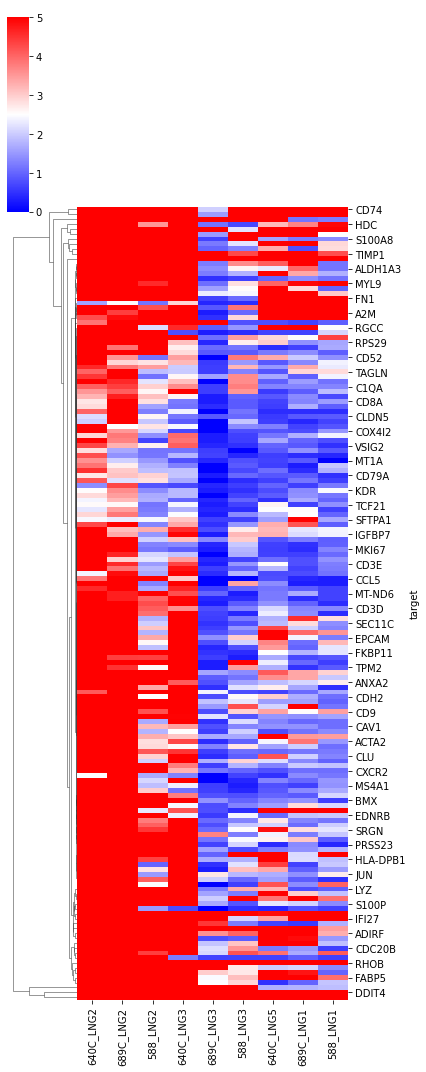

In [31]:
plt.figure(figsize=(10,10))
sns.clustermap(ep,figsize=(6,15),cmap='bwr',vmax=5,col_cluster=False)

# Axes consistency

In [31]:
gge=[exp640C_LNG2,exp588_LNG2,exp689_LNG2,exp640C_LNG3,
exp588_LNG3,exp689_LNG3,exp640C_LNG5,exp588_LNG1,exp689_LNG1]

In [32]:
gg=[]
for g in gge:
    gg.append(g.div(np.sum(g.sum()))*100)

<Figure size 432x288 with 0 Axes>

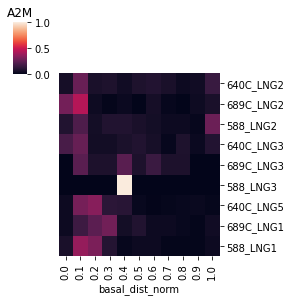

<Figure size 432x288 with 0 Axes>

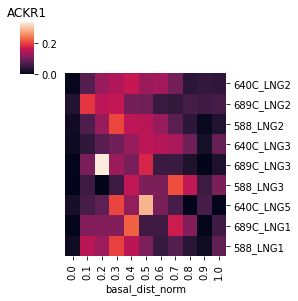

<Figure size 432x288 with 0 Axes>

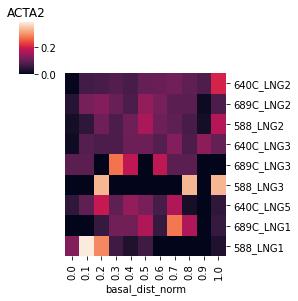

<Figure size 432x288 with 0 Axes>

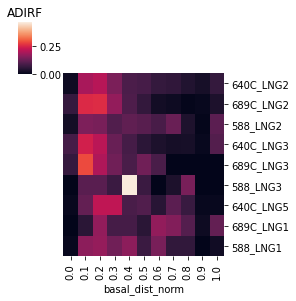

<Figure size 432x288 with 0 Axes>

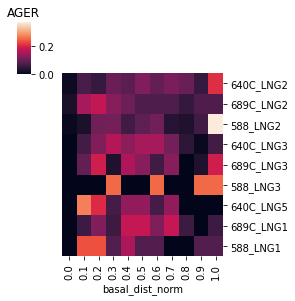

<Figure size 432x288 with 0 Axes>

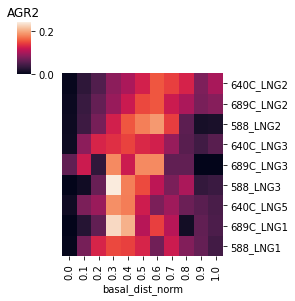

<Figure size 432x288 with 0 Axes>

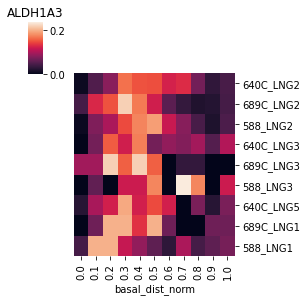

<Figure size 432x288 with 0 Axes>

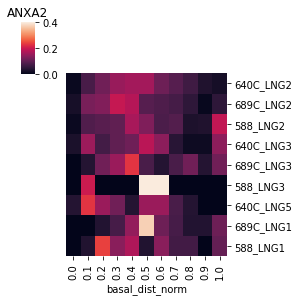

<Figure size 432x288 with 0 Axes>

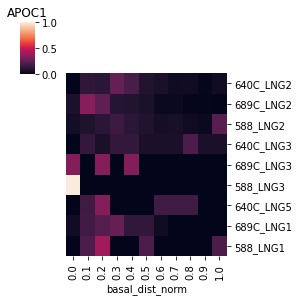

<Figure size 432x288 with 0 Axes>

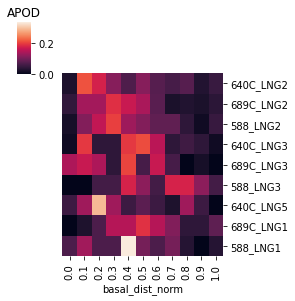

<Figure size 432x288 with 0 Axes>

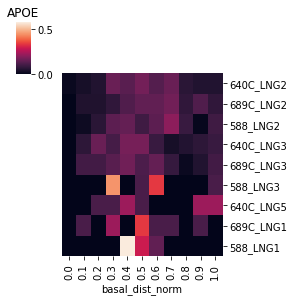

<Figure size 432x288 with 0 Axes>

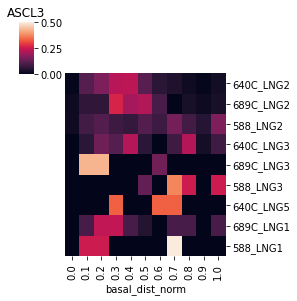

<Figure size 432x288 with 0 Axes>

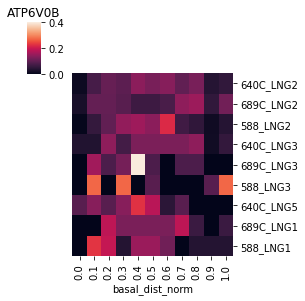

<Figure size 432x288 with 0 Axes>

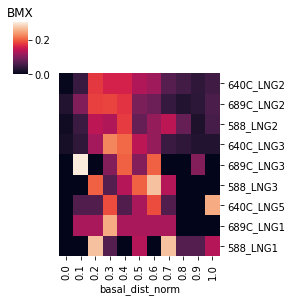

<Figure size 432x288 with 0 Axes>

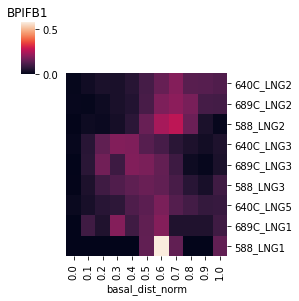

<Figure size 432x288 with 0 Axes>

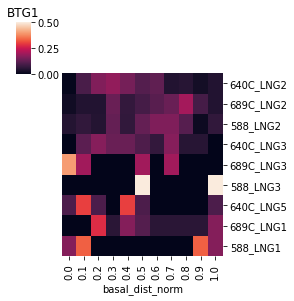

<Figure size 432x288 with 0 Axes>

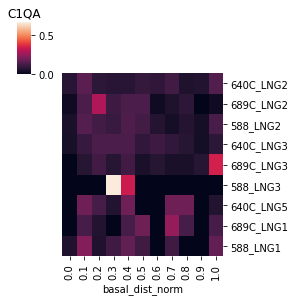

<Figure size 432x288 with 0 Axes>

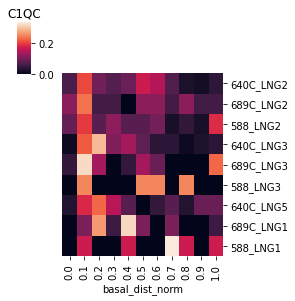

<Figure size 432x288 with 0 Axes>

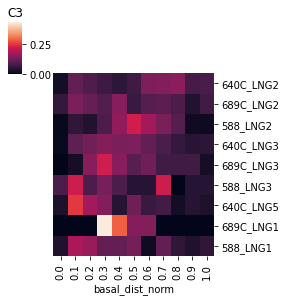

<Figure size 432x288 with 0 Axes>

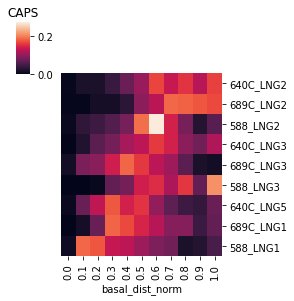

<Figure size 432x288 with 0 Axes>

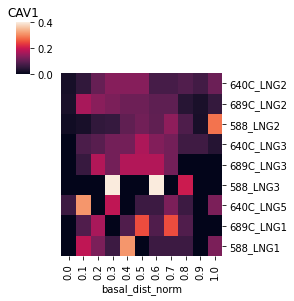

<Figure size 432x288 with 0 Axes>

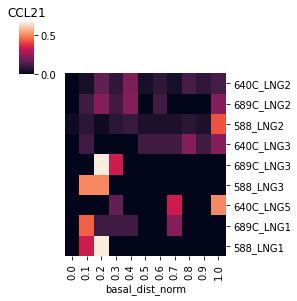

<Figure size 432x288 with 0 Axes>

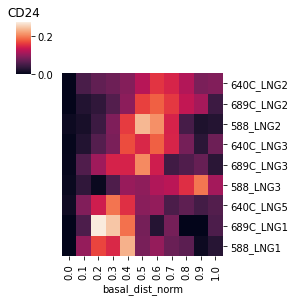

<Figure size 432x288 with 0 Axes>

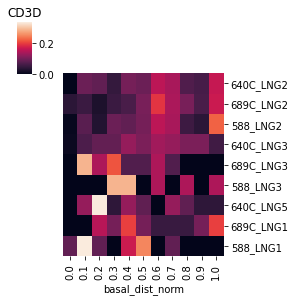

<Figure size 432x288 with 0 Axes>

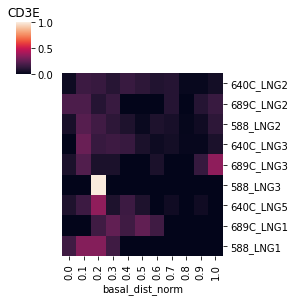

<Figure size 432x288 with 0 Axes>

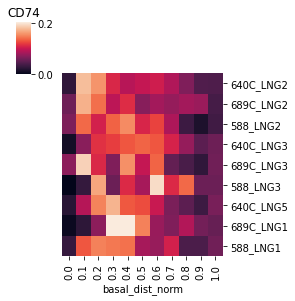

<Figure size 432x288 with 0 Axes>

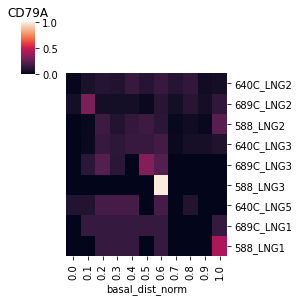

<Figure size 432x288 with 0 Axes>

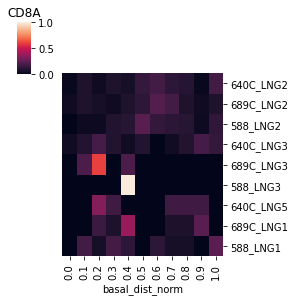

<Figure size 432x288 with 0 Axes>

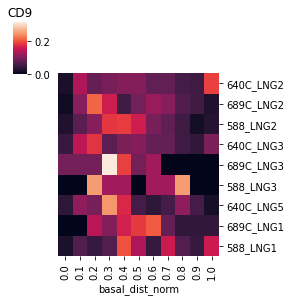

<Figure size 432x288 with 0 Axes>

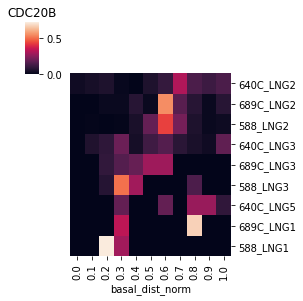

<Figure size 432x288 with 0 Axes>

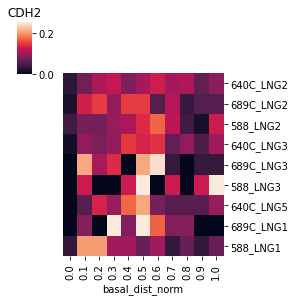

<Figure size 432x288 with 0 Axes>

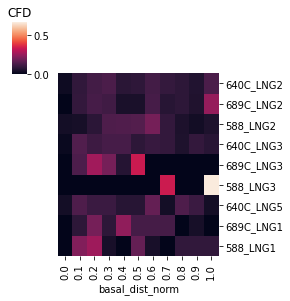

<Figure size 432x288 with 0 Axes>

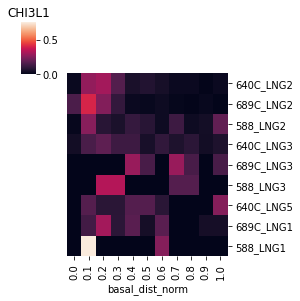

<Figure size 432x288 with 0 Axes>

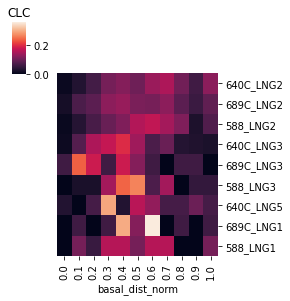

<Figure size 432x288 with 0 Axes>

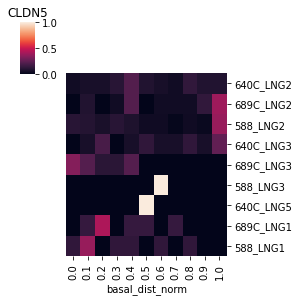

<Figure size 432x288 with 0 Axes>

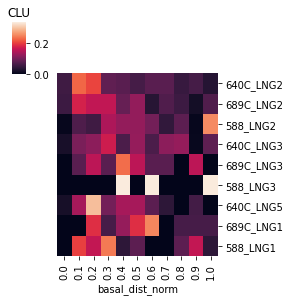

<Figure size 432x288 with 0 Axes>

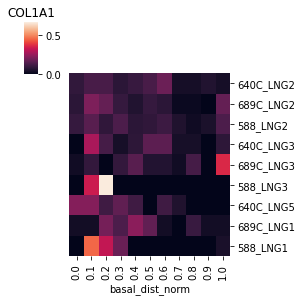

<Figure size 432x288 with 0 Axes>

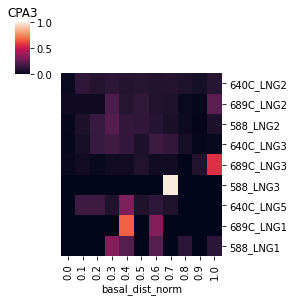

<Figure size 432x288 with 0 Axes>

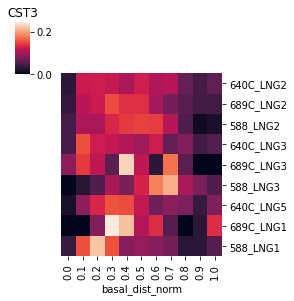

<Figure size 432x288 with 0 Axes>

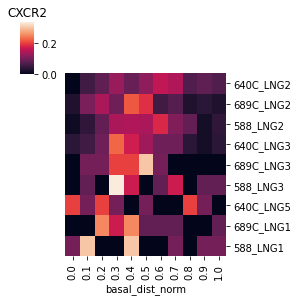

<Figure size 432x288 with 0 Axes>

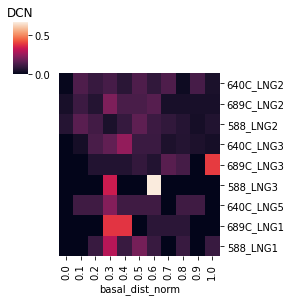

<Figure size 432x288 with 0 Axes>

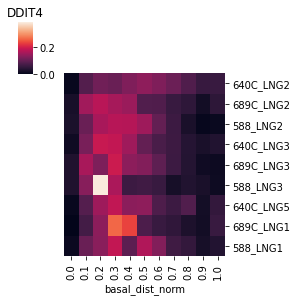

<Figure size 432x288 with 0 Axes>

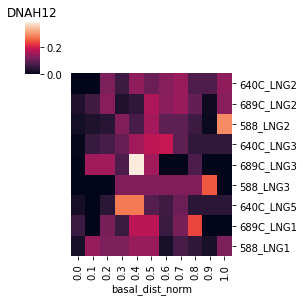

<Figure size 432x288 with 0 Axes>

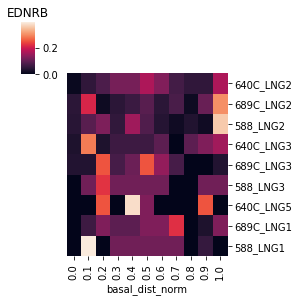

<Figure size 432x288 with 0 Axes>

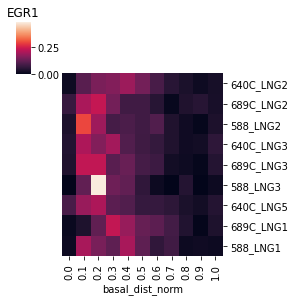

<Figure size 432x288 with 0 Axes>

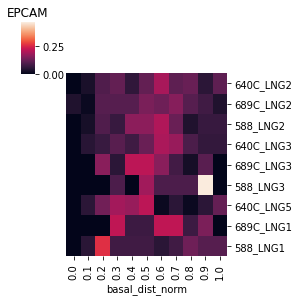

<Figure size 432x288 with 0 Axes>

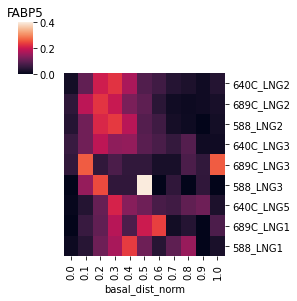

<Figure size 432x288 with 0 Axes>

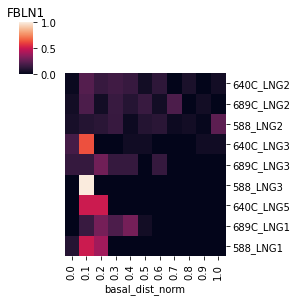

<Figure size 432x288 with 0 Axes>

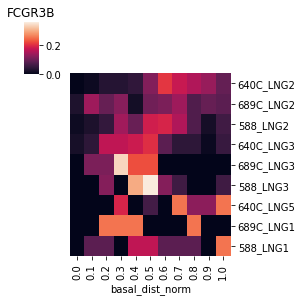

<Figure size 432x288 with 0 Axes>

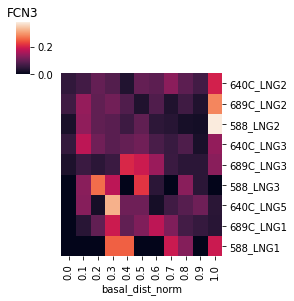

<Figure size 432x288 with 0 Axes>

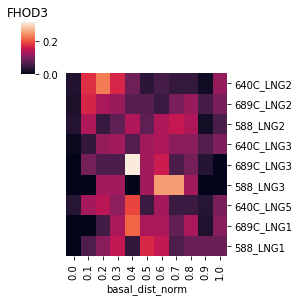

<Figure size 432x288 with 0 Axes>

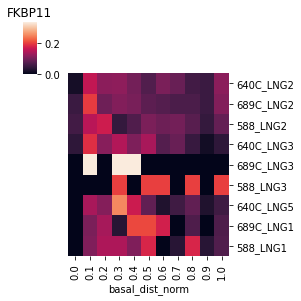

<Figure size 432x288 with 0 Axes>

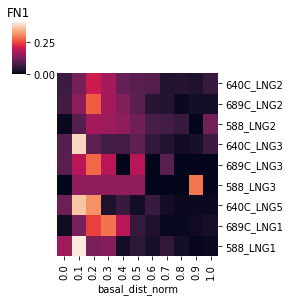

<Figure size 432x288 with 0 Axes>

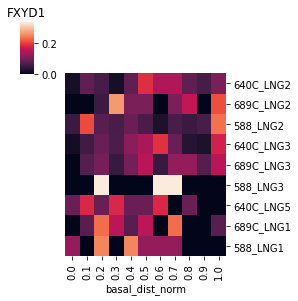

<Figure size 432x288 with 0 Axes>

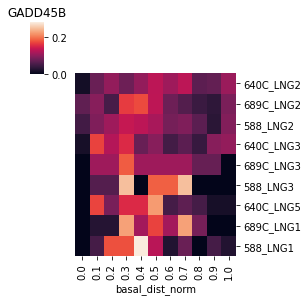

<Figure size 432x288 with 0 Axes>

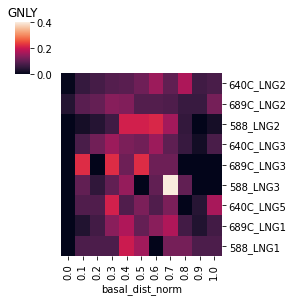

<Figure size 432x288 with 0 Axes>

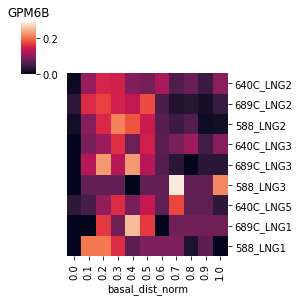

<Figure size 432x288 with 0 Axes>

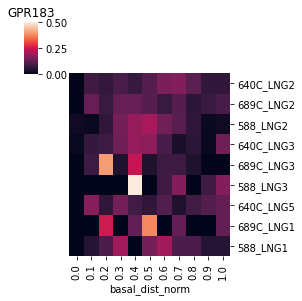

<Figure size 432x288 with 0 Axes>

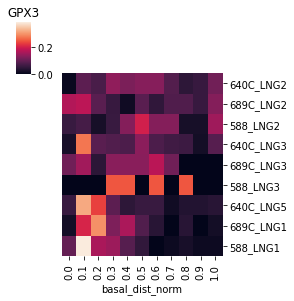

<Figure size 432x288 with 0 Axes>

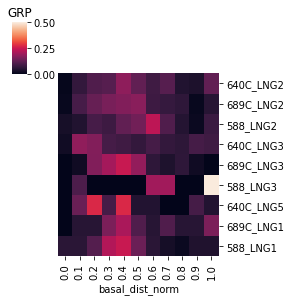

<Figure size 432x288 with 0 Axes>

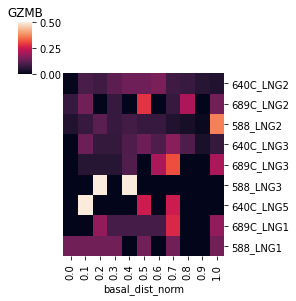

<Figure size 432x288 with 0 Axes>

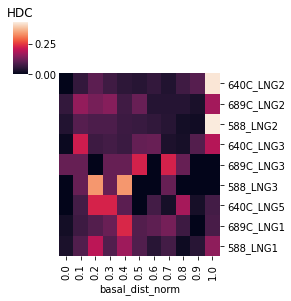

<Figure size 432x288 with 0 Axes>

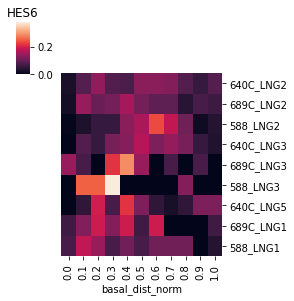

<Figure size 432x288 with 0 Axes>

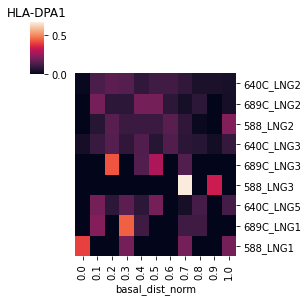

<Figure size 432x288 with 0 Axes>

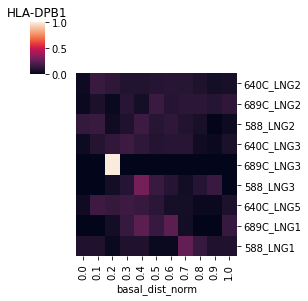

<Figure size 432x288 with 0 Axes>

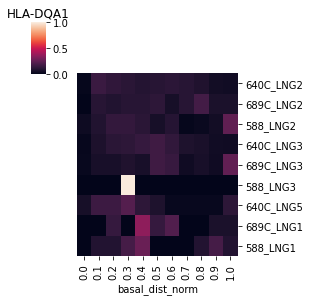

<Figure size 432x288 with 0 Axes>

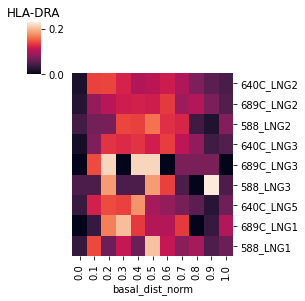

<Figure size 432x288 with 0 Axes>

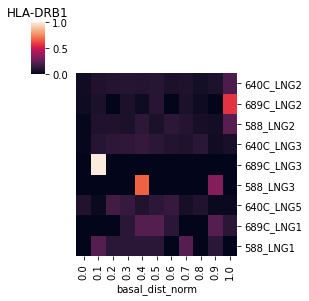

<Figure size 432x288 with 0 Axes>

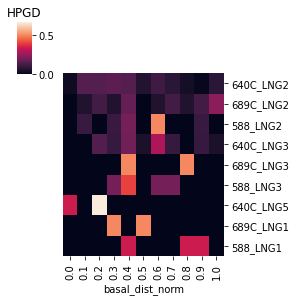

<Figure size 432x288 with 0 Axes>

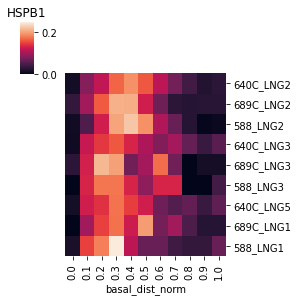

<Figure size 432x288 with 0 Axes>

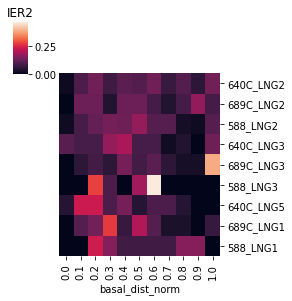

<Figure size 432x288 with 0 Axes>

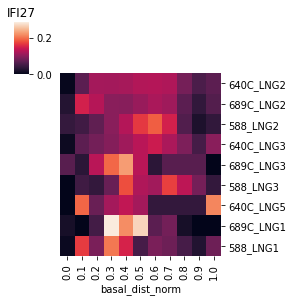

<Figure size 432x288 with 0 Axes>

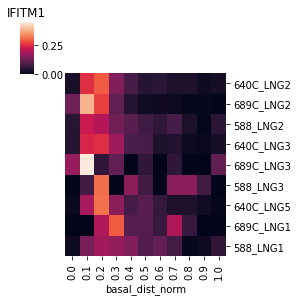

<Figure size 432x288 with 0 Axes>

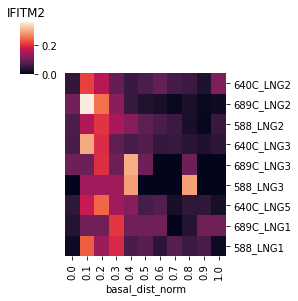

<Figure size 432x288 with 0 Axes>

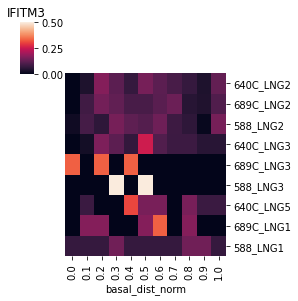

<Figure size 432x288 with 0 Axes>

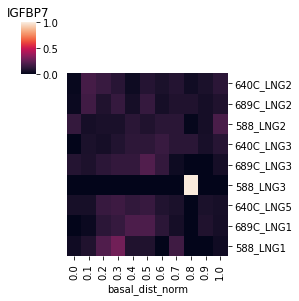

<Figure size 432x288 with 0 Axes>

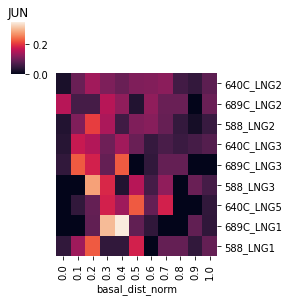

<Figure size 432x288 with 0 Axes>

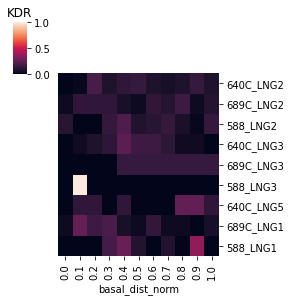

<Figure size 432x288 with 0 Axes>

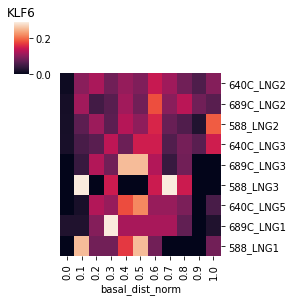

<Figure size 432x288 with 0 Axes>

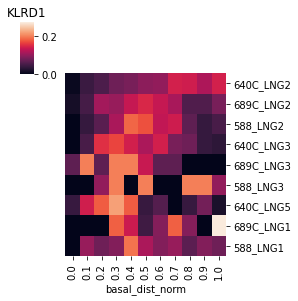

<Figure size 432x288 with 0 Axes>

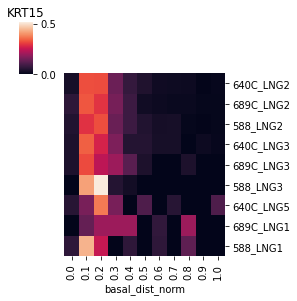

<Figure size 432x288 with 0 Axes>

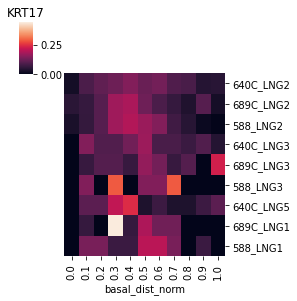

<Figure size 432x288 with 0 Axes>

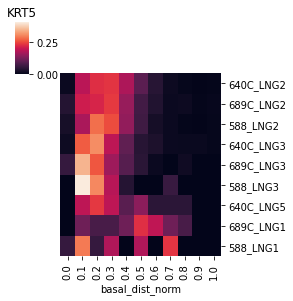

<Figure size 432x288 with 0 Axes>

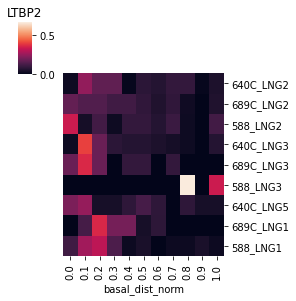

<Figure size 432x288 with 0 Axes>

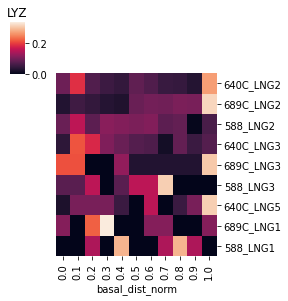

<Figure size 432x288 with 0 Axes>

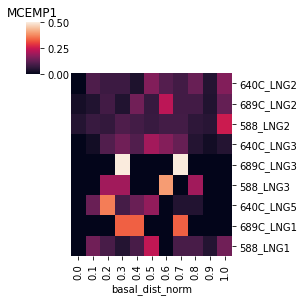

<Figure size 432x288 with 0 Axes>

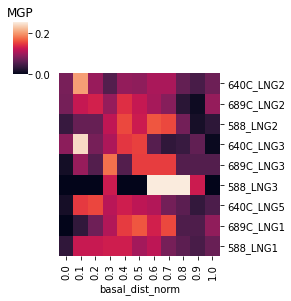

<Figure size 432x288 with 0 Axes>

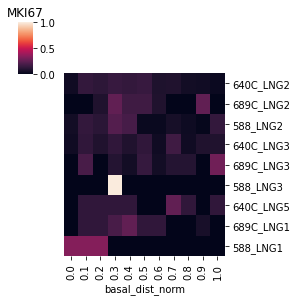

<Figure size 432x288 with 0 Axes>

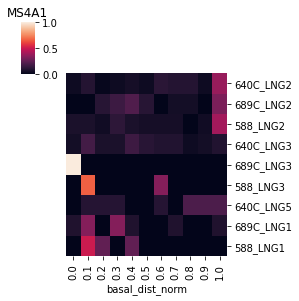

<Figure size 432x288 with 0 Axes>

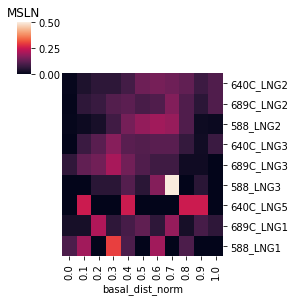

<Figure size 432x288 with 0 Axes>

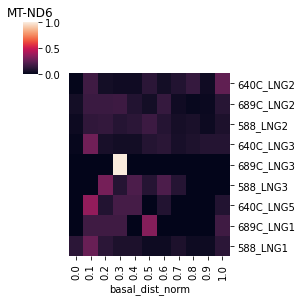

<Figure size 432x288 with 0 Axes>

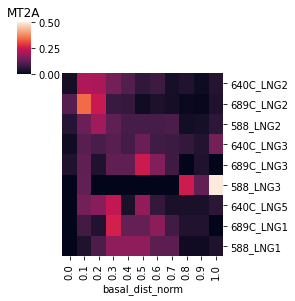

<Figure size 432x288 with 0 Axes>

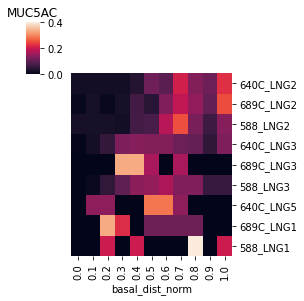

<Figure size 432x288 with 0 Axes>

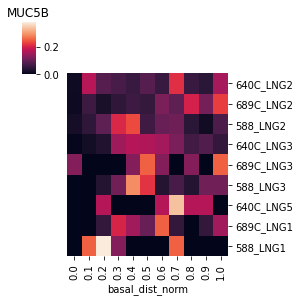

<Figure size 432x288 with 0 Axes>

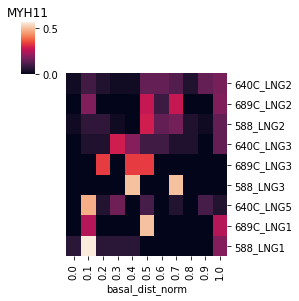

<Figure size 432x288 with 0 Axes>

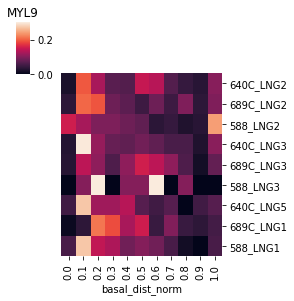

<Figure size 432x288 with 0 Axes>

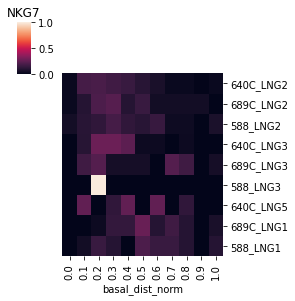

<Figure size 432x288 with 0 Axes>

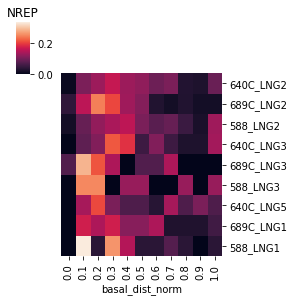

<Figure size 432x288 with 0 Axes>

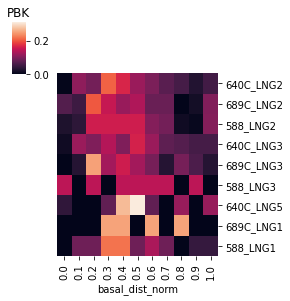

<Figure size 432x288 with 0 Axes>

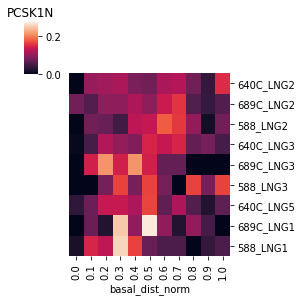

<Figure size 432x288 with 0 Axes>

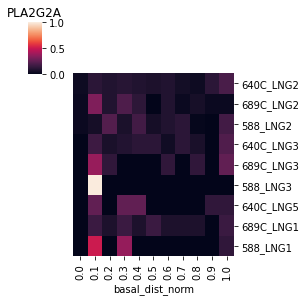

<Figure size 432x288 with 0 Axes>

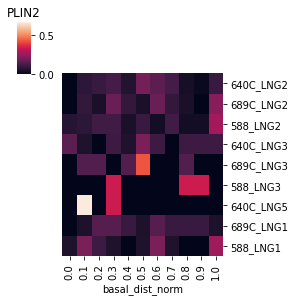

<Figure size 432x288 with 0 Axes>

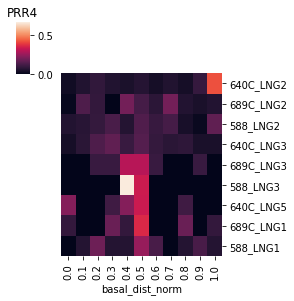

<Figure size 432x288 with 0 Axes>

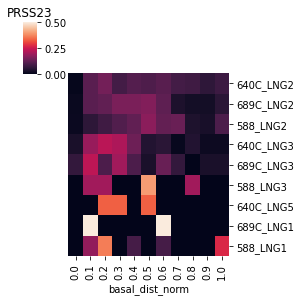

<Figure size 432x288 with 0 Axes>

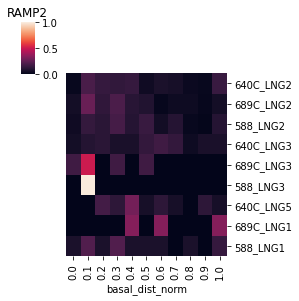

<Figure size 432x288 with 0 Axes>

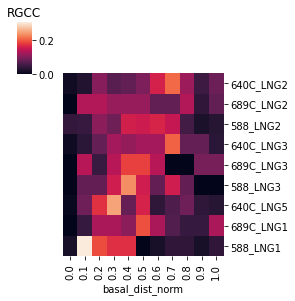

<Figure size 432x288 with 0 Axes>

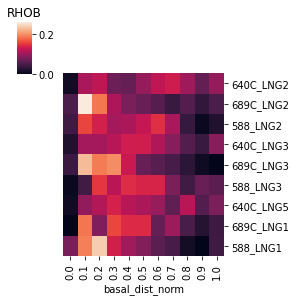

<Figure size 432x288 with 0 Axes>

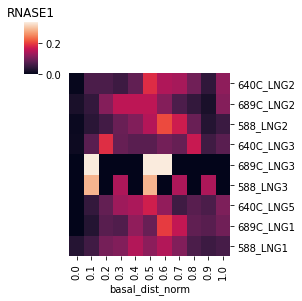

<Figure size 432x288 with 0 Axes>

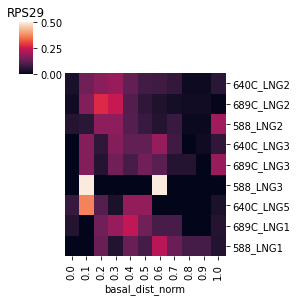

<Figure size 432x288 with 0 Axes>

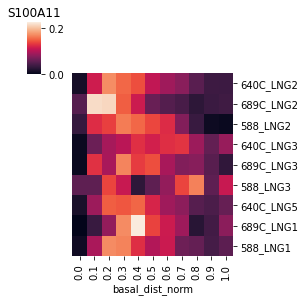

<Figure size 432x288 with 0 Axes>

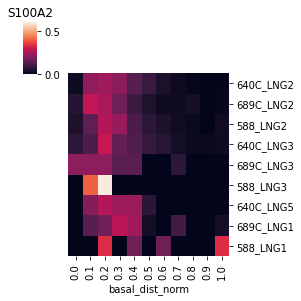

<Figure size 432x288 with 0 Axes>

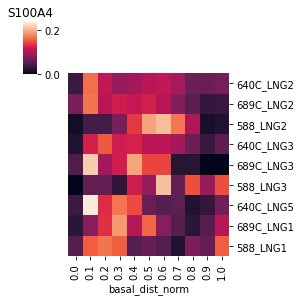

<Figure size 432x288 with 0 Axes>

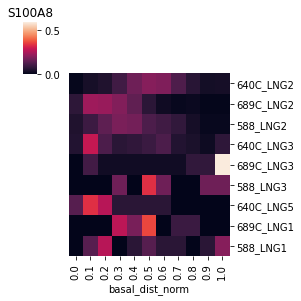

<Figure size 432x288 with 0 Axes>

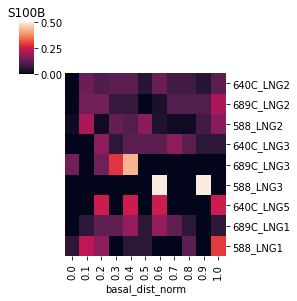

<Figure size 432x288 with 0 Axes>

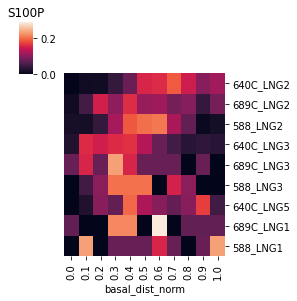

<Figure size 432x288 with 0 Axes>

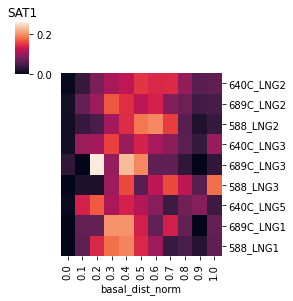

<Figure size 432x288 with 0 Axes>

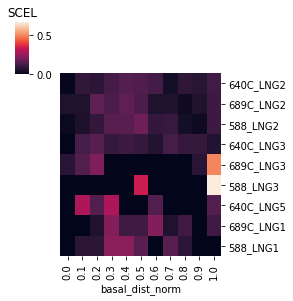

<Figure size 432x288 with 0 Axes>

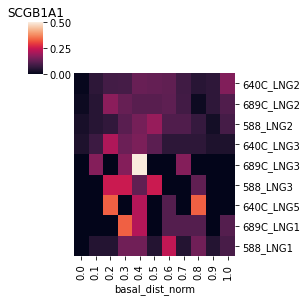

<Figure size 432x288 with 0 Axes>

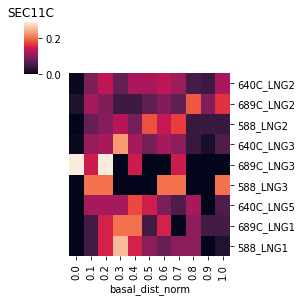

<Figure size 432x288 with 0 Axes>

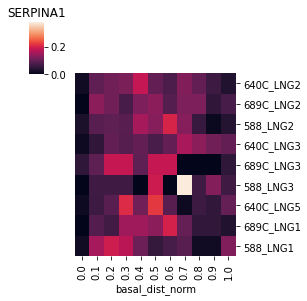

<Figure size 432x288 with 0 Axes>

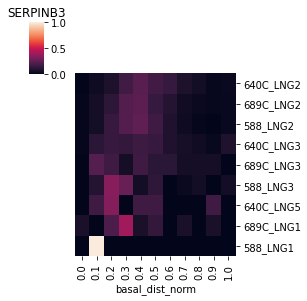

<Figure size 432x288 with 0 Axes>

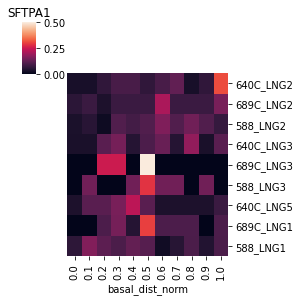

<Figure size 432x288 with 0 Axes>

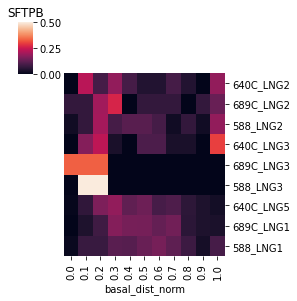

<Figure size 432x288 with 0 Axes>

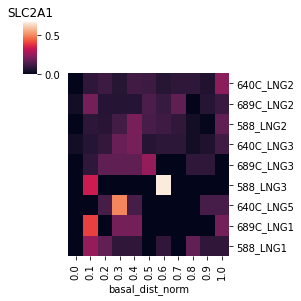

<Figure size 432x288 with 0 Axes>

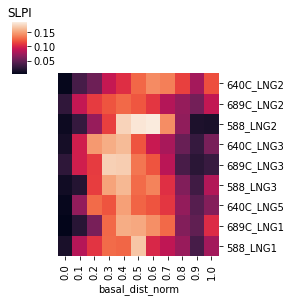

<Figure size 432x288 with 0 Axes>

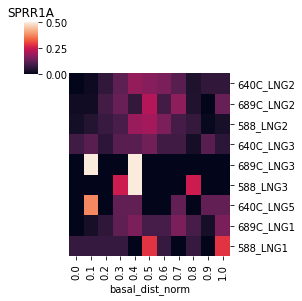

<Figure size 432x288 with 0 Axes>

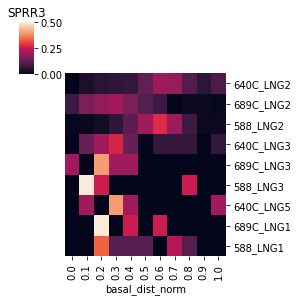

<Figure size 432x288 with 0 Axes>

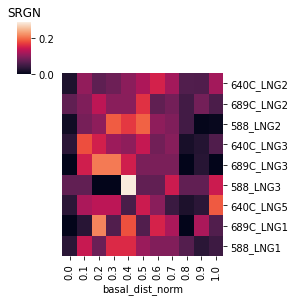

<Figure size 432x288 with 0 Axes>

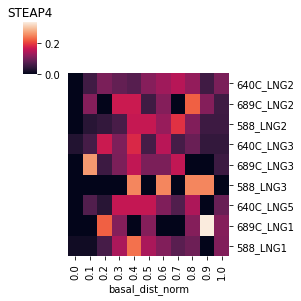

<Figure size 432x288 with 0 Axes>

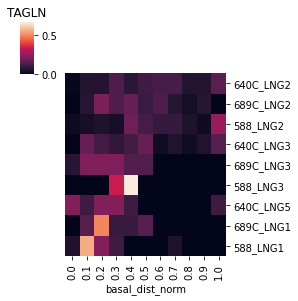

<Figure size 432x288 with 0 Axes>

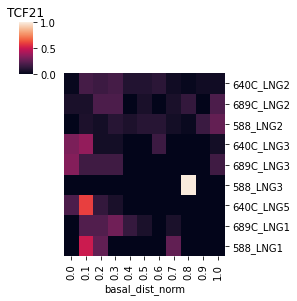

<Figure size 432x288 with 0 Axes>

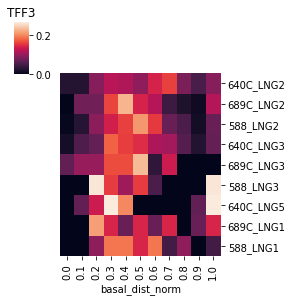

<Figure size 432x288 with 0 Axes>

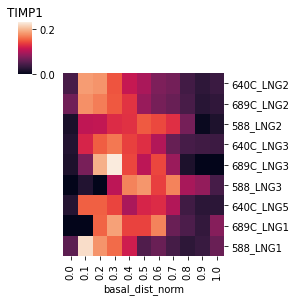

<Figure size 432x288 with 0 Axes>

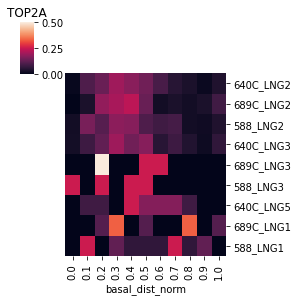

<Figure size 432x288 with 0 Axes>

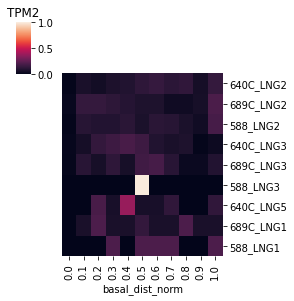

<Figure size 432x288 with 0 Axes>

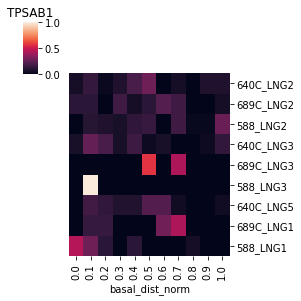

<Figure size 432x288 with 0 Axes>

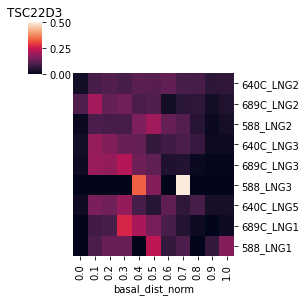

<Figure size 432x288 with 0 Axes>

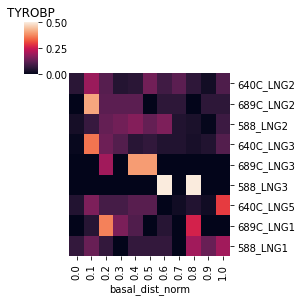

<Figure size 432x288 with 0 Axes>

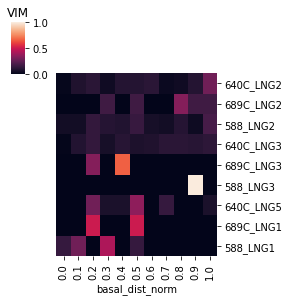

<Figure size 432x288 with 0 Axes>

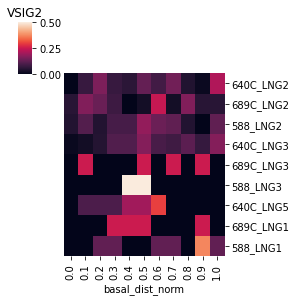

<Figure size 432x288 with 0 Axes>

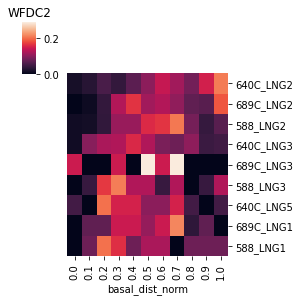

<Figure size 432x288 with 0 Axes>

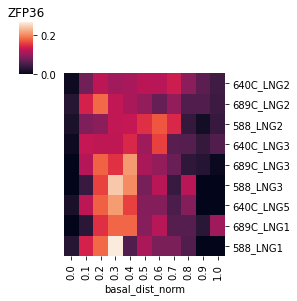

In [33]:
for g in gg[0].index:
    out=pd.DataFrame(index=range(0,len(gg)),columns=gg[0].columns)
    tag=0
    try:
        for t in gg:
            out.loc[tag,:]=t.loc[g,:]
            tag=tag+1
        plt.figure()
        outdiv=out.div(out.sum(axis=1),axis=0)
        outdiv.index=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
        outdiv=outdiv.fillna(0)
        sns.clustermap(outdiv,col_cluster=False,row_cluster=False,figsize=(4,4))
        plt.title(g)
        plt.show()
    except:
        aa=2

# Comparison by expression

In [106]:
extr=exxp.transpose()

In [43]:
sample=[i.split('_')[0] for i in extr.index]
region=[i.split('_')[1].replace('LNG5','LNG1') for i in extr.index]

In [44]:
extr['sample']=sample
extr['region']=region

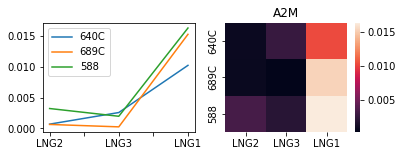

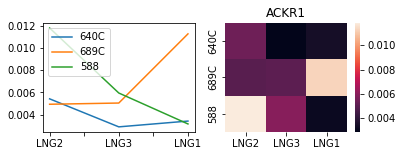

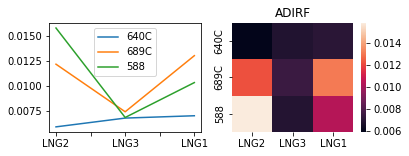

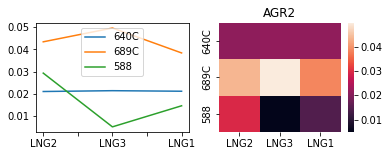

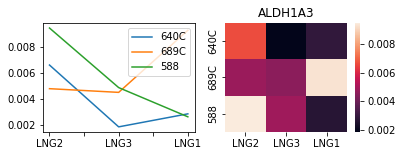

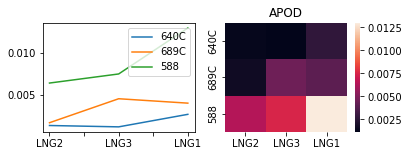

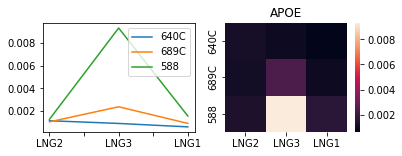

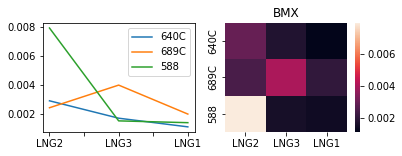

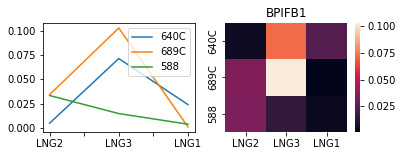

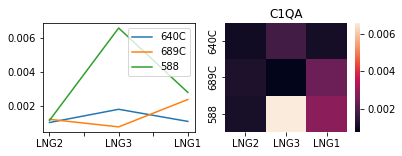

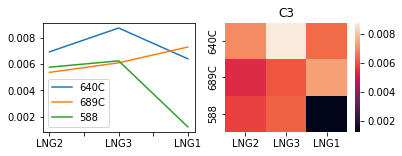

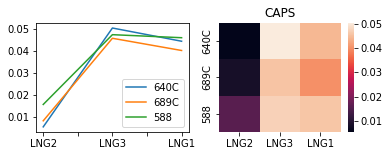

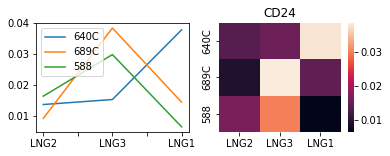

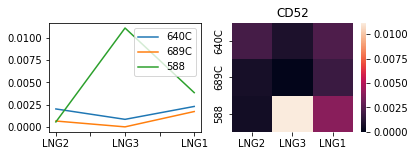

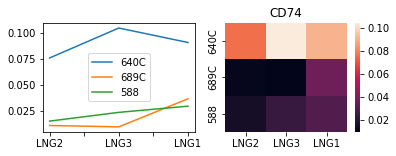

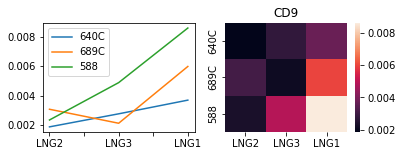

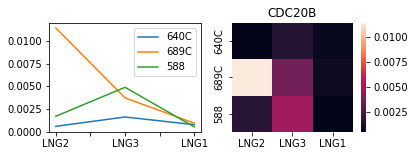

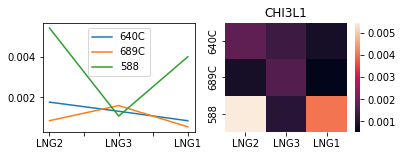

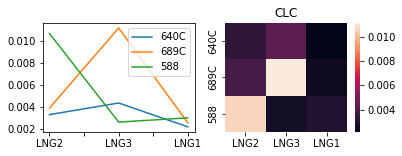

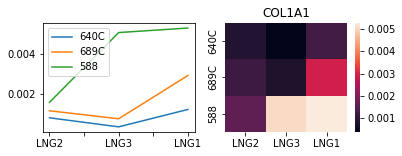

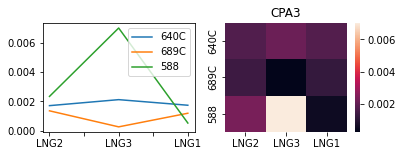

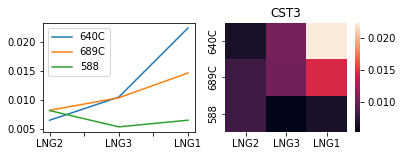

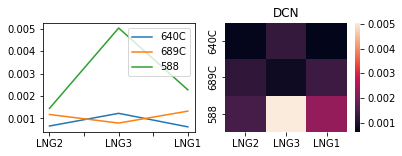

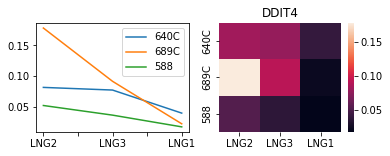

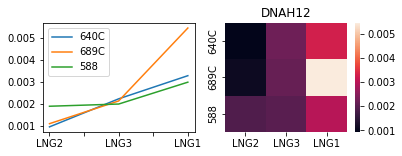

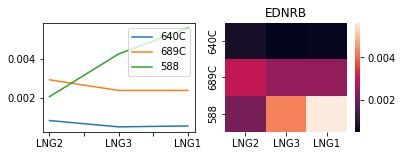

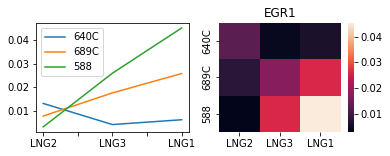

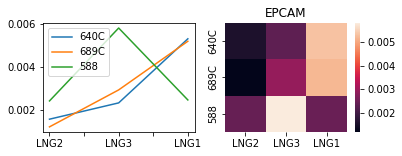

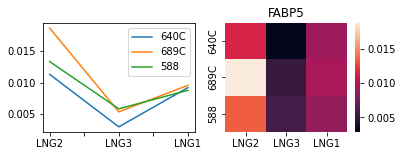

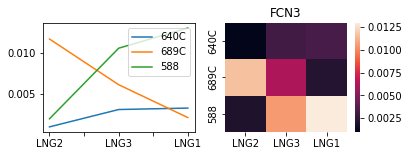

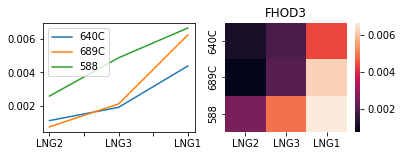

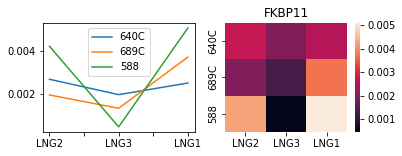

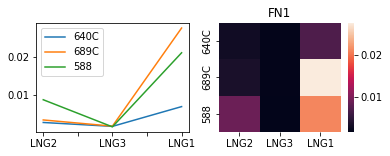

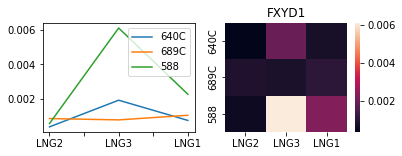

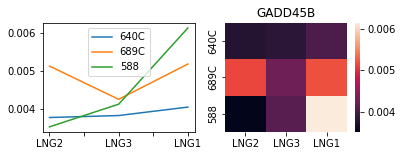

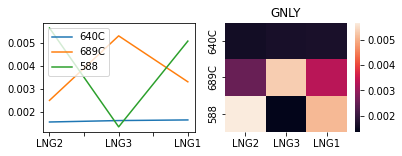

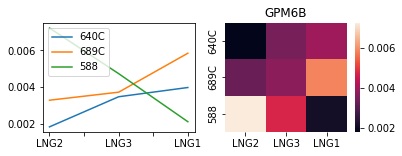

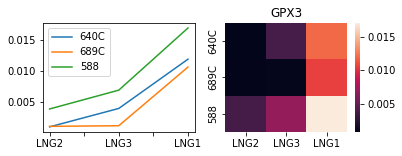

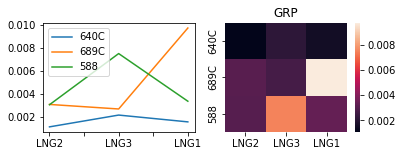

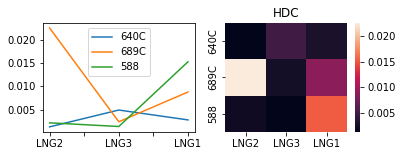

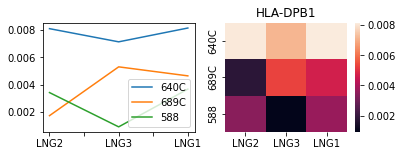

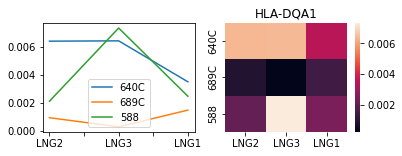

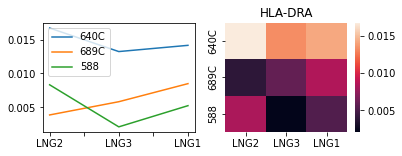

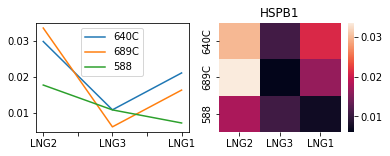

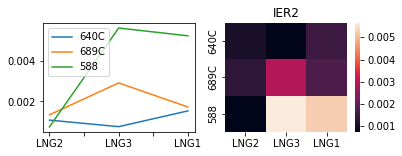

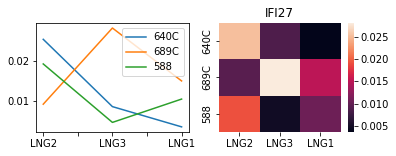

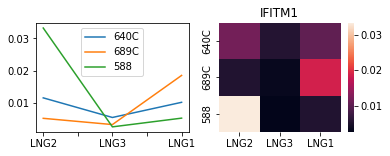

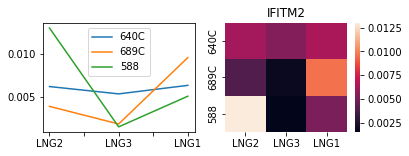

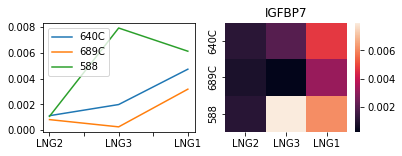

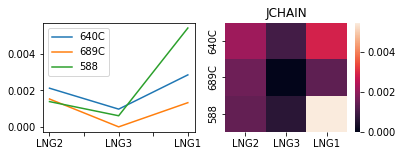

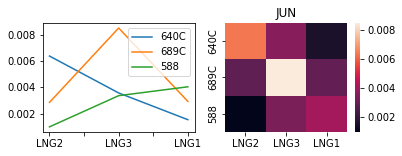

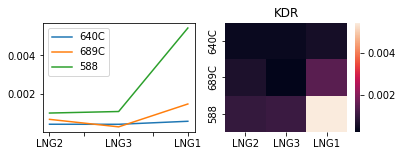

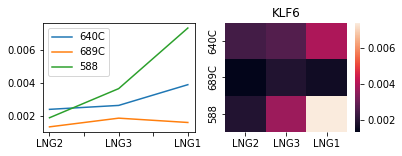

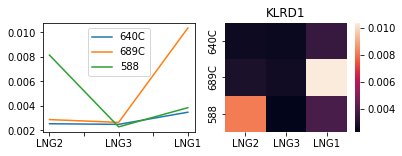

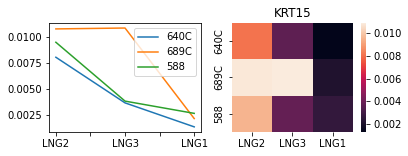

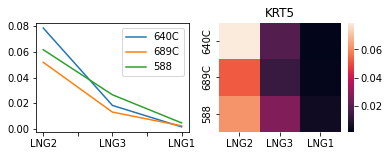

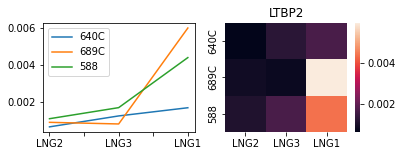

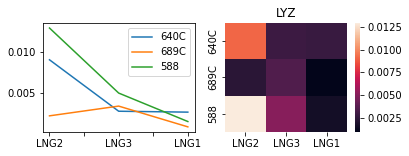

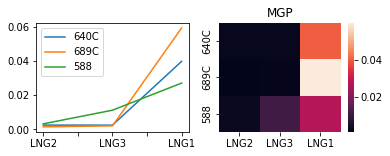

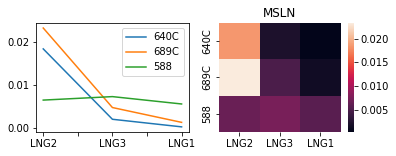

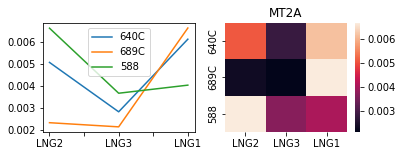

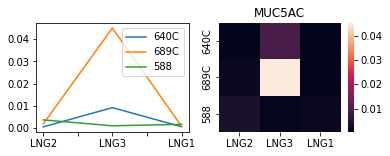

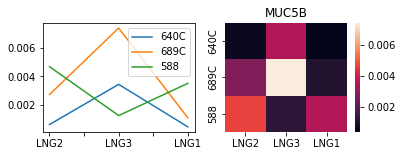

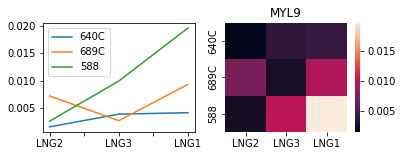

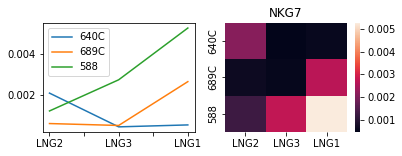

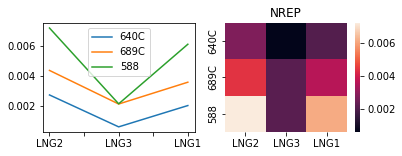

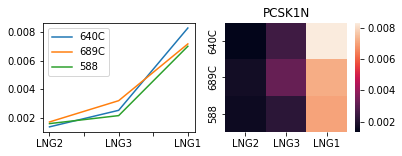

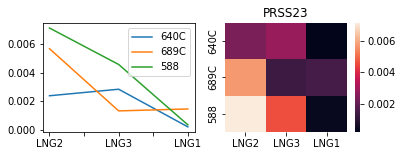

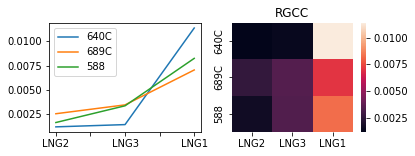

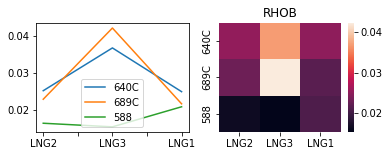

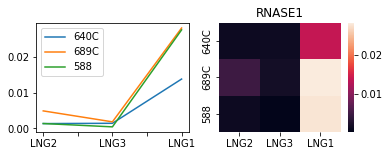

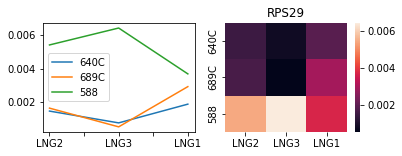

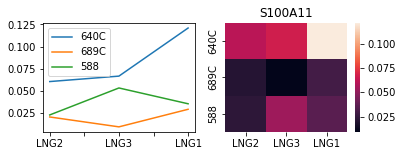

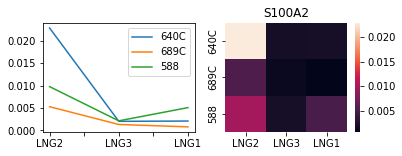

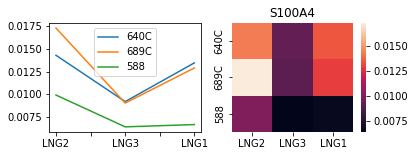

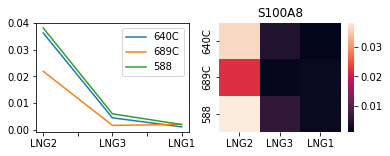

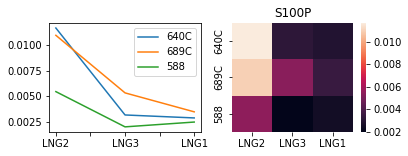

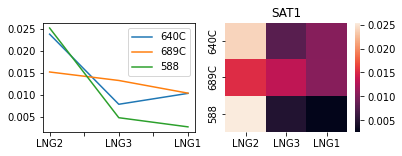

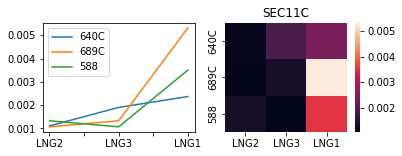

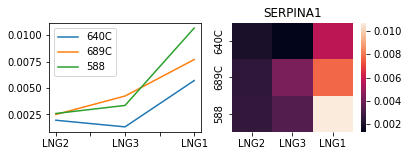

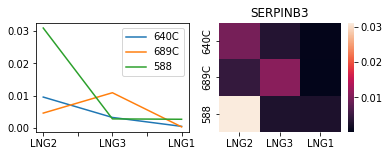

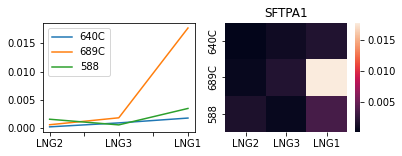

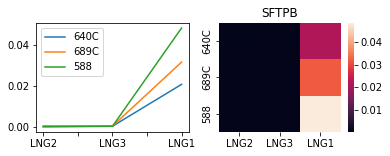

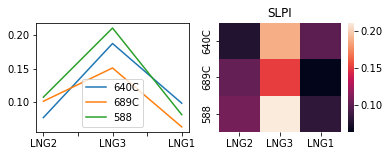

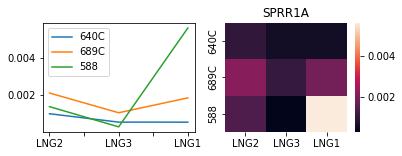

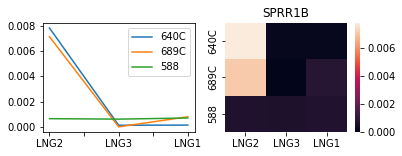

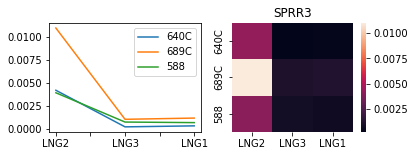

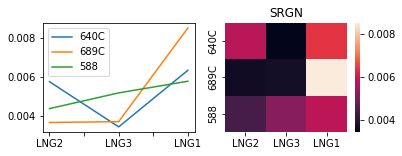

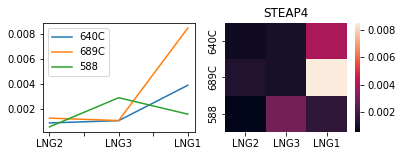

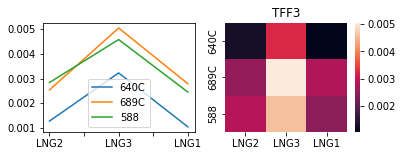

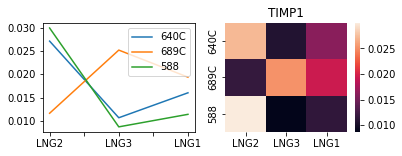

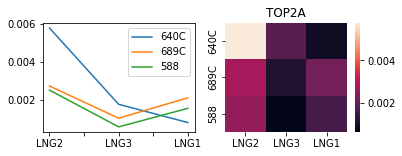

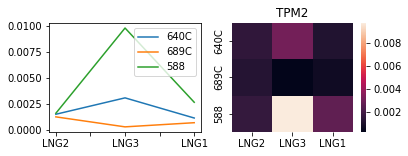

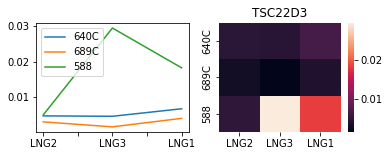

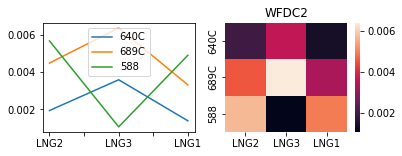

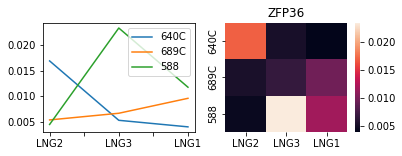

In [143]:
for g in extr.columns[:-2]:
    su=extr.loc[:,[g,'sample','region']]
    out=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())
    for ii in su.index:
        out.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
    out=out.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
    fig,ax=plt.subplots(1,2,figsize=(6,2))
    out.transpose().plot(ax=ax[0])
    sns.heatmap(out.astype(float),ax=ax[1]) #### enable this to plot as heatmap instead
    plt.title(g)
    plt.show()

# combined plots

In [30]:
names=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
ggg=0
for el in gg:
    expp=el.transpose()
    expp=expp.div(expp.sum(axis=0),axis=1)
    genes=['SERPINB3','KRT15','CAPS','KRT5']
    expp.loc[:,genes].plot(kind='area',stacked=False,figsize=(5,2))
    plt.legend(bbox_to_anchor=(1.5, 0.5),loc='right')
    plt.title(names[ggg])
    ggg=ggg+1

In [29]:
for g in np.mean(pvals2,axis=1).sort_values().head(10).index:#extr.columns[:-2]:
    out=pd.DataFrame(index=range(0,len(gg)),columns=gg[0].columns)
    tag=0
    try:
        for t in gg:
            out.loc[tag,:]=t.loc[g,:]
            tag=tag+1
        plt.figure()
        outdiv=out#.div(out.max()),axis=0)
        outdiv.index=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
        outdiv=outdiv.fillna(0)
        fig,ax=plt.subplots(1,2,figsize=(10,3))
        sns.heatmap(outdiv,ax=ax[0],cmap='Greens')
        ax[0].set_title('basal apical '+g)
        plt.title(g)
        ### distribution
        su=extr.loc[:,[g,'sample','region']]
        outs=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())
        for ii in su.index:
            outs.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
        outs=outs.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
      #  out.transpose().plot(ax=ax[1])
        outs=outs.fillna(0)
        sns.heatmap(outs.astype(float),ax=ax[1],cmap='Blues') #### enable this to plot as heatmap instead
        plt.title('abundancy_change '+g)
        plt.show()

        
    except:
        aa=2

NameError: name 'gg' is not defined

# Test for significance

In [23]:
#640
SMP=[EPI640C_LNG2,EPI689_LNG2,EPI588_LNG2,EPI640C_LNG3,
EPI689_LNG3,EPI588_LNG3,EPI640C_LNG5,EPI689_LNG1,EPI588_LNG1]

nams=['640_LNG2','689_LNG2','588_LNG2','640_LNG3',
'689_LNG3','588_LNG3','640_LNG5','689_LNG1','588_LNG1']


In [24]:
lista=[]
sss=0
for esa in SMP:
    pvals=[]
    ks=[]
    gns=[]
    for gr,tr in esa.groupby('target'):
        from scipy.stats import kstest
        random_distribution = np.random.uniform(0, 1, 1000)
        # Perform the test
        ks_statistic, p_value = kstest(tr['basal_dist'],esa['basal_dist'])
        ks.append(ks_statistic)
        pvals.append(p_value)
        gns.append(gr)
    kssum=pd.DataFrame([pvals,ks,gns],index=['pvals','ks','gene']).transpose()
    kssum['sample']=nams[sss]
    sss=sss+1
    lista.append(kssum)

In [25]:
reset=pd.concat(lista).reset_index()
pvalsall=pd.DataFrame(index=reset['gene'].unique(),columns=reset['sample'].unique())
for i in reset.index:
    pvalsall.loc[reset.loc[i,'gene'],reset.loc[i,'sample']]=reset.loc[i,'pvals']

In [26]:
pvalsall=pvalsall.fillna(1)
pvals2=pvalsall.loc[:,['640_LNG2', '689_LNG2', '588_LNG2']]

In [27]:
np.mean(pvals2,axis=1).sort_values().head(20)

KRT5        1.274848e-127
BPIFB1       1.420306e-62
CAPS         1.635324e-52
AGR2         3.218897e-46
KRT15        1.152471e-43
SLPI         6.206212e-42
S100A8       5.653122e-37
CD24         4.530006e-34
S100A2       2.479392e-30
IFITM1       1.618472e-27
S100A11      8.615457e-21
IFITM2       3.249671e-18
FABP5        3.472790e-18
SAT1         3.570229e-18
WFDC2        5.598475e-16
SERPINB3     2.799269e-15
RHOB         1.451514e-14
CDC20B       2.679153e-13
HSPB1        4.365852e-13
MSLN         2.317794e-11
dtype: float64

In [97]:
genes2plot=pvals2.index[list(np.mean(pvals2,axis=1)<0.001)]

In [ ]:
#640
SMP=[EPI640C_LNG2,EPI689_LNG2,EPI588_LNG2,EPI640C_LNG3,
EPI689_LNG3,EPI588_LNG3,EPI640C_LNG5,EPI689_LNG1,EPI588_LNG1]

nams=['640_LNG2','689_LNG2','588_LNG2','640_LNG3',
'689_LNG3','588_LNG3','640_LNG5','689_LNG1','588_LNG1']


In [256]:
def combine(i1='e',i2='i',i3='s'):
    cct=pd.concat([i1,i2])
    cct2=pd.concat([cct,i3])
    cct3=cct2.loc[:,['target','basal_dist']]
    cct4=cct3.groupby('target').mean()
    genes_in_order=cct4.loc[cct4.index.isin(genes2plot),:].sort_values(by='basal_dist')
    genes=['IFITM2','IFITM1','KRT15','S100A2','KRT5','SERPINB3','AGR2','MSLN','CAPS','BPIFB1']
    ccts=cct3[cct3['target'].isin(genes)]
    ccts['basal_dist_norm']=ccts['basal_dist'].round(2)
    exp=pd.crosstab(ccts['basal_dist_norm'],ccts['target']).transpose()
    #exp=exp.div(exp.sum(axis=1),axis=0)
    exp=exp.iloc[:,1:-1]
    return exp

In [265]:
exp_lng2=combine(EPI640C_LNG2,EPI689_LNG2,EPI588_LNG2)
exp_lng2=exp_lng2.div(exp_lng2.sum(axis=1),axis=0)
exp_lng3=combine(EPI640C_LNG3,EPI689_LNG3,EPI588_LNG3)
exp_lng3=exp_lng3.div(exp_lng3.sum(axis=1),axis=0)
exp_lng1=combine(EPI640C_LNG5,EPI689_LNG1,EPI588_LNG1)
exp_lng1=exp_lng1.div(exp_lng1.sum(axis=1),axis=0)

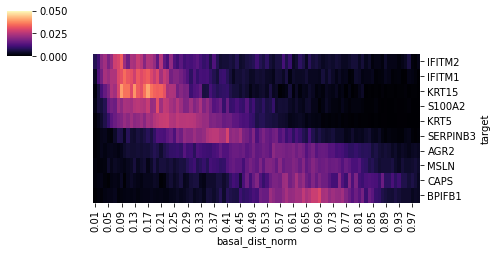

In [243]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.clustermap(exp.loc[genes,:],cmap='magma',col_cluster=False,row_cluster=False,figsize=(7,3.5),vmax=0.05)
plt.savefig('/mnt/f/ISS/plots_for_publication/lng2_distribution_apicobasal.pdf')

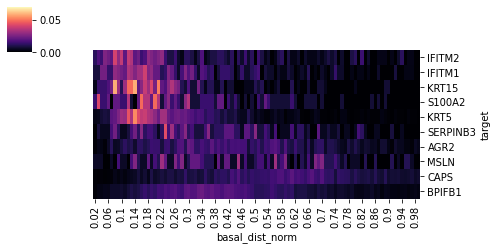

In [254]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.clustermap(exp_lng3.loc[genes,:],cmap='magma',col_cluster=False,row_cluster=False,figsize=(7,3.5),vmax=0.07)
plt.savefig('/mnt/f/ISS/plots_for_publication/lng3_distribution_apicobasal.pdf')

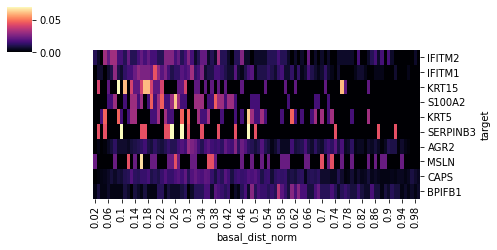

In [253]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.clustermap(exp_lng1.loc[genes,:],cmap='magma',col_cluster=False,row_cluster=False,figsize=(7,3.5),vmax=0.07)
plt.savefig('/mnt/f/ISS/plots_for_publication/lng1_distribution_apicobasal.pdf')

In [277]:
exxi=exx.loc[genes,['640C_LNG2','689C_LNG2', '588_LNG2', '588_LNG3','689C_LNG3', '640C_LNG3', '640C_LNG5', '689C_LNG1',
        '588_LNG1',]]
exxi=exxi.div(exxi.sum(axis=1),axis=0)

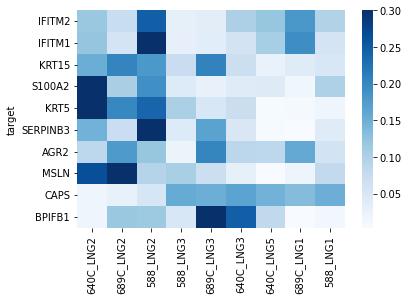

In [282]:
sns.heatmap(exxi,cmap='Blues',vmax=0.3)
plt.savefig('/mnt/f/ISS/plots_for_publication/expression_across samples.pdf')

In [273]:
epith_std.loc[genes_in_order.index,['640C_LNG2','689C_LNG2', '588_LNG2', '588_LNG3','689C_LNG3', '640C_LNG3', '640C_LNG5', '689C_LNG1',
        '588_LNG1',]]

640C_LNG2  689C_LNG2  588_LNG2  588_LNG3  689C_LNG3  640C_LNG3   
target                                                                     
KRT15           982        952       308      25.0       41.0        228  \
IFITM1         1424        474      1076      18.0       13.0        353   
S100A2         2780        466       316      14.0        5.0        127   
KRT5           9594       4580      2001     174.0       49.0       1141   
MT2A            618        204       215      24.0        8.0        176   
FABP5          1380       1652       433      38.0       20.0        182   
IFITM2          756        344       421      10.0        7.0        335   
A2M              86         58       105      13.0        1.0        162   
EGR1           1587        674        98     170.0       66.0        251   
RPS29           179        145       175      42.0        2.0         48   
ADIRF           723       1073       511      45.0       28.0        426   
APOD            160        145       207      49.0       17.0         72   
APOC1           130        128        99       3.0        1.0         15   
S100A11        7388       1825       745     350.0       36.0       4178   
HSPB1          3641       2964       575      71.0       23.0        679   
DDIT4          9989      15727      1703     242.0      346.0       4860   
SERPINB3       1162        401      1005      18.0       41.0        200   
S100A8         4434       1936      1239      39.0        6.0        278   
HLA-DPB1        988        153       111       6.0       20.0        447   
RHOB           3073       2019       531     101.0      159.0       2304   
IFI27          3088        815       623      31.0      106.0        541   
SAT1           2913       1342       820      31.0       50.0        489   
AGR2           2558       3828       949      33.0      187.0       1337   
SLPI           9374       8931      3482    1381.0      569.0      11739   
APOE            142         94        42      61.0        9.0         58   
LYZ            1106        200       419      33.0       13.0        177   
SPRR3           515        970       128       5.0        4.0         15   
PRR4            104        280        66      10.0        3.0        109   
CLC             399        341       345      17.0       42.0        271   
EPCAM           190        106        78      38.0       11.0        145   
KLRD1           310        254       264      15.0       10.0        156   
HLA-DRB1        296         83        28       1.0        3.0        237   
CD24           1672        812       532     196.0      145.0        960   
MSLN           2247       2054       211      48.0       18.0        128   
MCEMP1          128        147        69       2.0        5.0         84   
FCN3            122       1026        64      69.0       23.0        194   
S100P          1421        965       176      13.0       20.0        197   
DNAH12          115         96        61      13.0        8.0        139   
CD3D            130        130        78      14.0        7.0        105   
WFDC2           237        396       184       7.0       24.0        225   
FCGR3B          405        149       108       9.0       17.0         96   
CDC20B           71       1006        55      32.0       14.0        101   
BPIFB1          574       3010      1079      96.0      388.0       4474   
CCL5             93         79        57       NaN        NaN         51   
CAPS            669        726       507     310.0      172.0       3149   
MUC5AC           53        155       116       6.0      170.0        571   

          640C_LNG5  689C_LNG1  588_LNG1  
target                                    
KRT15            19         16      15.0  
IFITM1          148        140      31.0  
S100A2           30          6      29.0  
KRT5             21         17      26.0  
MT2A             88         50      23.0  
FABP5           132         72      50.0  
IFITM2           

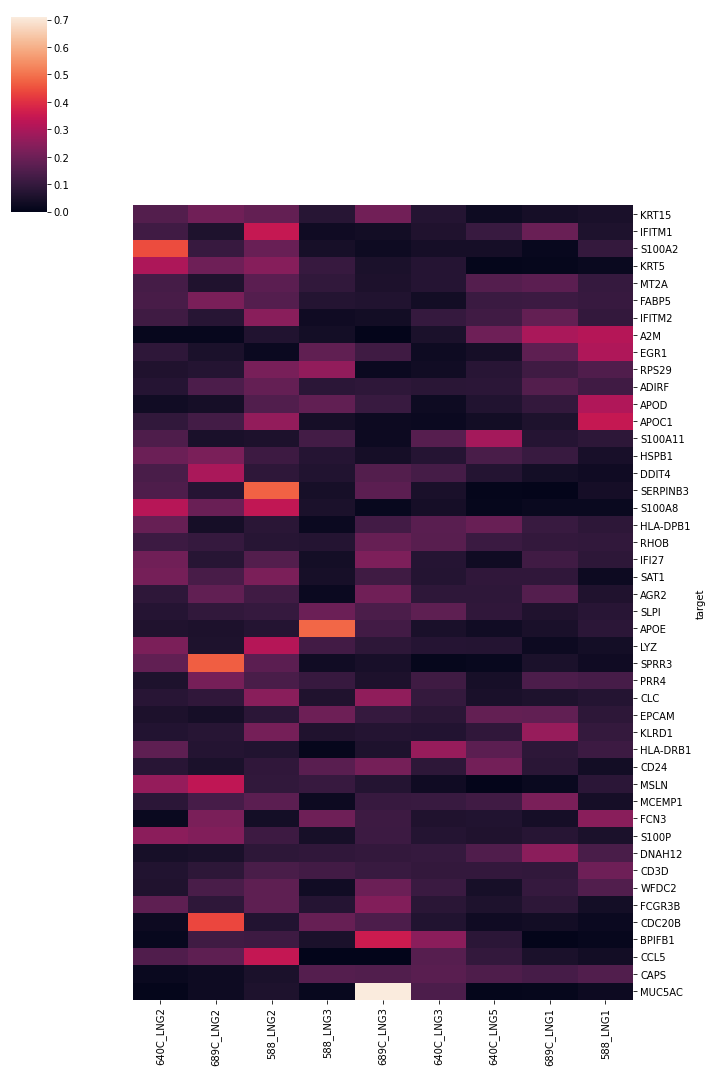

In [145]:
sns.clustermap(exxi,row_cluster=False,col_cluster=False,figsize=(10,15))

In [ ]:
outs=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())

In [ ]:
out=pd.DataFrame(index=range(0,len(gg)),columns=gene2plot)
for g in genes2plot:#extr.columns[:-2]:

    su=extr.loc[:,[g,'sample','region']]
    
    for ii in su.index:
        outs.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
    outs=outs.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
  #  out.transpose().plot(ax=ax[1])
    outs=outs.fillna(0)
    sns.heatmap(outs.astype(float),ax=ax[1],cmap='Blues') #### enable this to plot as heatmap instead
    plt.title('abundancy_change '+g)
    plt.show()


<Figure size 432x288 with 0 Axes>

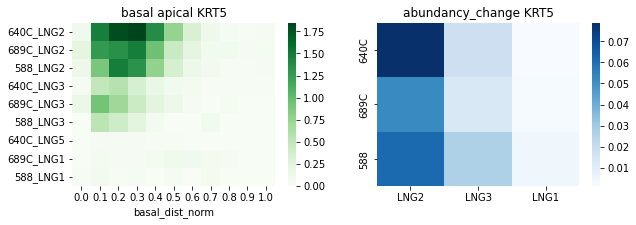

<Figure size 432x288 with 0 Axes>

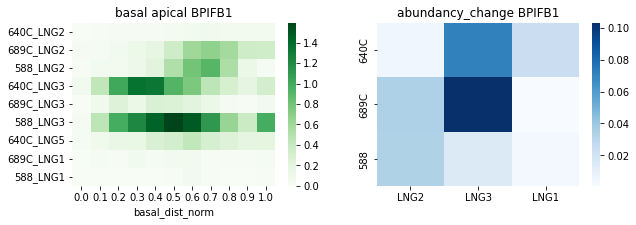

<Figure size 432x288 with 0 Axes>

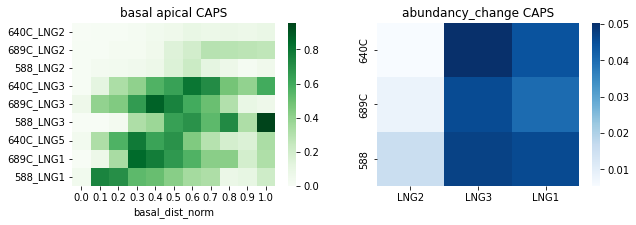

<Figure size 432x288 with 0 Axes>

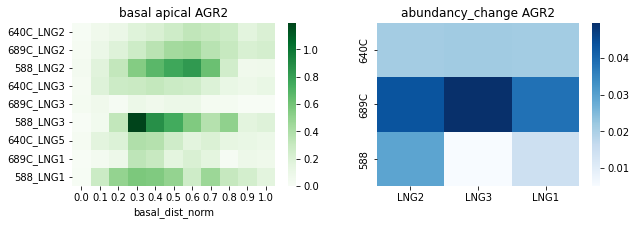

<Figure size 432x288 with 0 Axes>

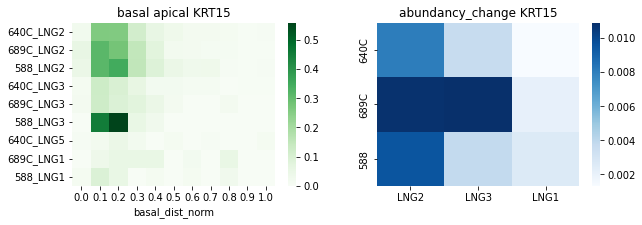

<Figure size 432x288 with 0 Axes>

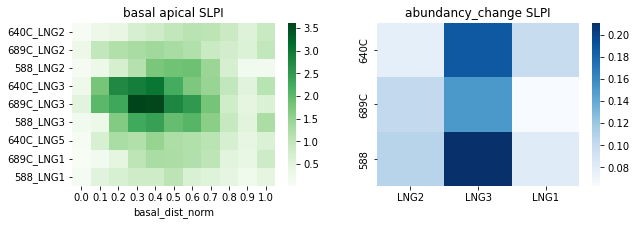

<Figure size 432x288 with 0 Axes>

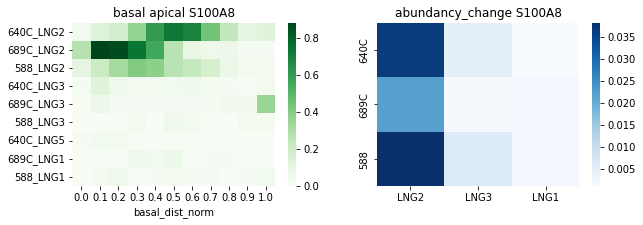

<Figure size 432x288 with 0 Axes>

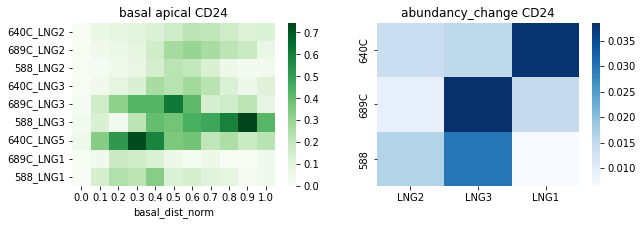

<Figure size 432x288 with 0 Axes>

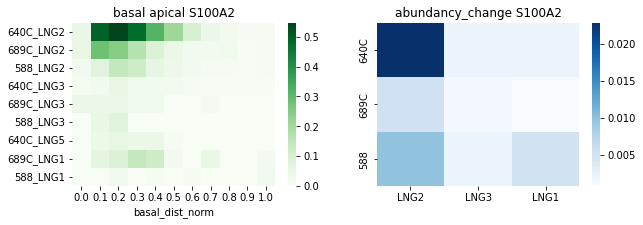

<Figure size 432x288 with 0 Axes>

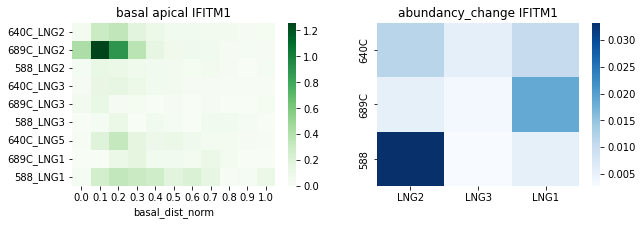

<Figure size 432x288 with 0 Axes>

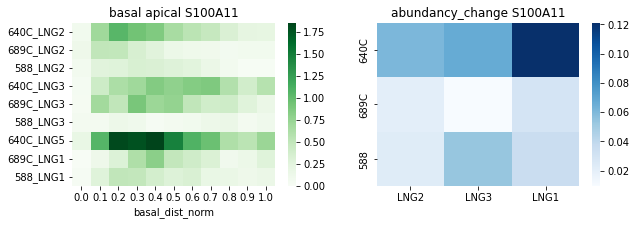

<Figure size 432x288 with 0 Axes>

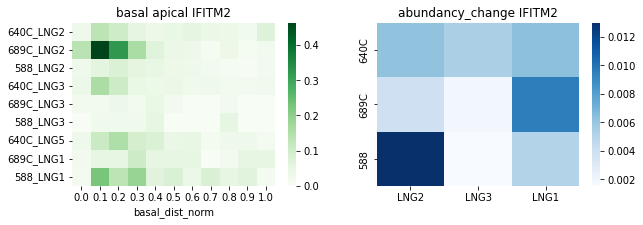

<Figure size 432x288 with 0 Axes>

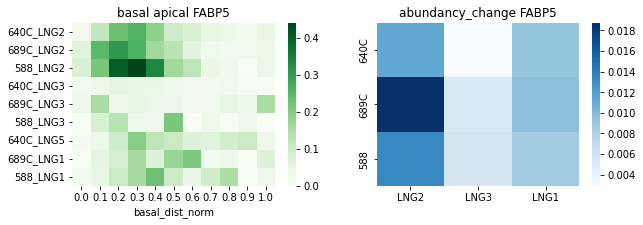

<Figure size 432x288 with 0 Axes>

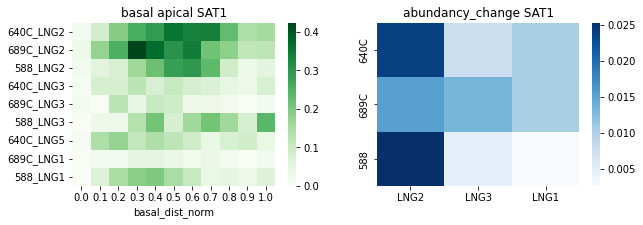

<Figure size 432x288 with 0 Axes>

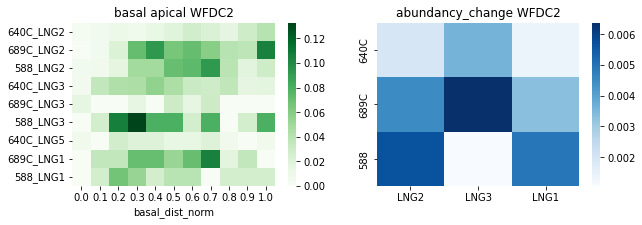

<Figure size 432x288 with 0 Axes>

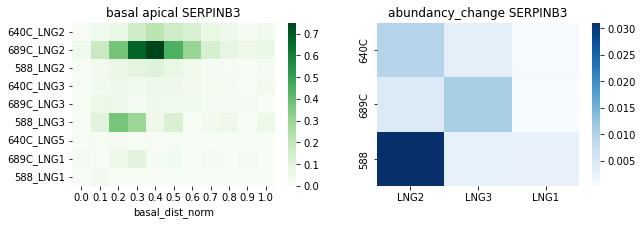

<Figure size 432x288 with 0 Axes>

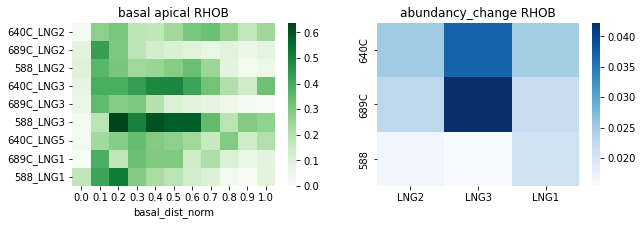

<Figure size 432x288 with 0 Axes>

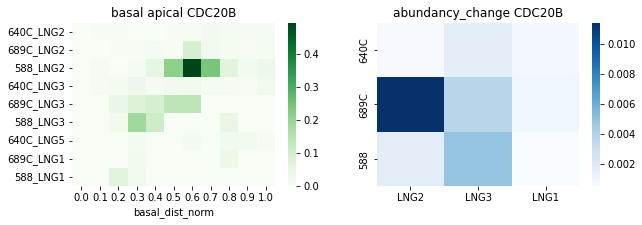

<Figure size 432x288 with 0 Axes>

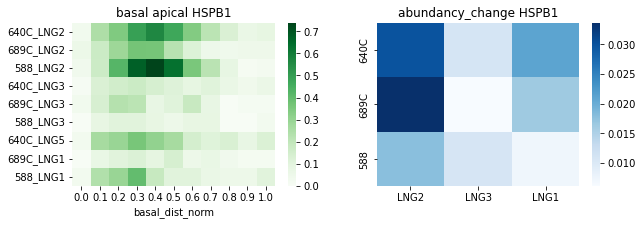

<Figure size 432x288 with 0 Axes>

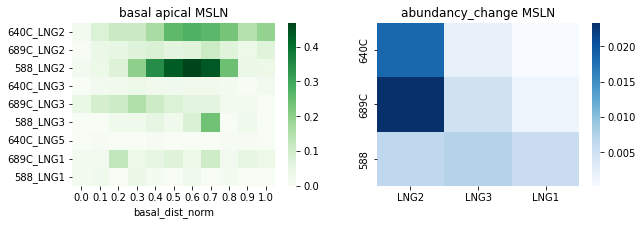

In [47]:
for g in np.mean(pvals2,axis=1).sort_values().head(20).index:#extr.columns[:-2]:
    out=pd.DataFrame(index=range(0,len(gg)),columns=gg[0].columns)
    tag=0
    try:
        for t in gg:
            out.loc[tag,:]=t.loc[g,:]
            tag=tag+1
        plt.figure()
        outdiv=out#.div(out.max()),axis=0)
        outdiv.index=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
        outdiv=outdiv.fillna(0)
        fig,ax=plt.subplots(1,2,figsize=(10,3))
        sns.heatmap(outdiv,ax=ax[0],cmap='Greens')
        ax[0].set_title('basal apical '+g)
        plt.title(g)
        ### distribution
        su=extr.loc[:,[g,'sample','region']]
        outs=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())
        for ii in su.index:
            outs.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
        outs=outs.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
      #  out.transpose().plot(ax=ax[1])
        outs=outs.fillna(0)
        sns.heatmap(outs.astype(float),ax=ax[1],cmap='Blues') #### enable this to plot as heatmap instead
        plt.title('abundancy_change '+g)
        plt.show()

        
    except:
        aa=2

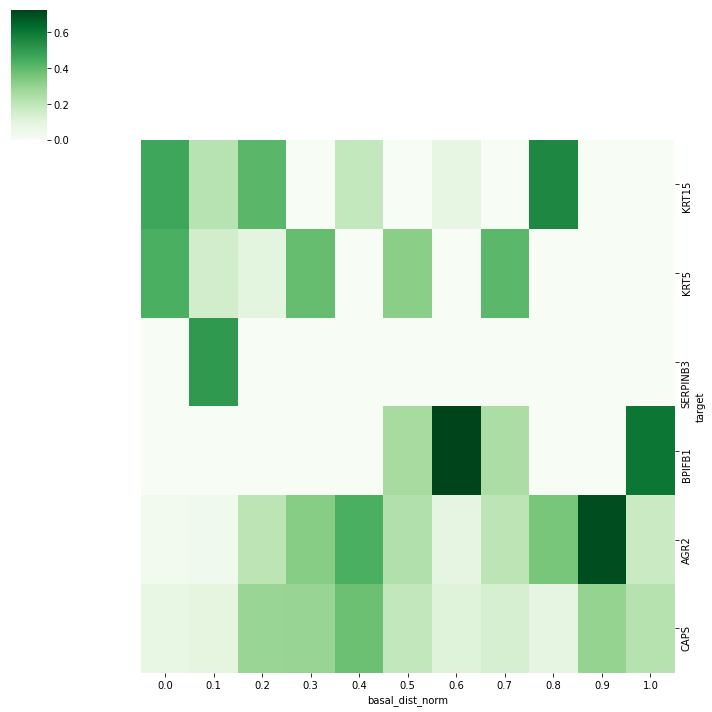

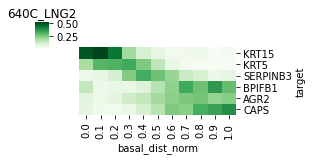

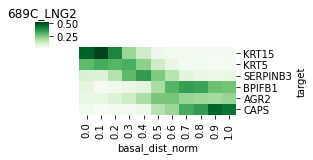

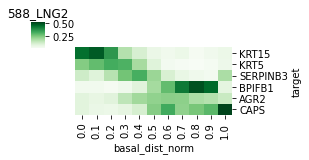

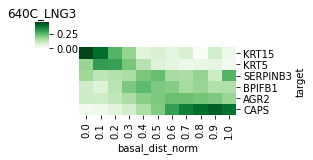

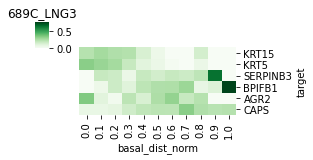

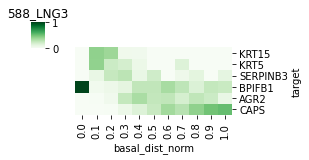

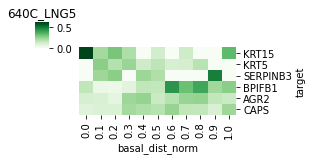

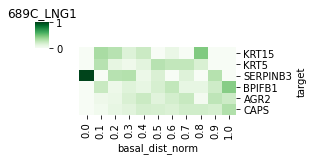

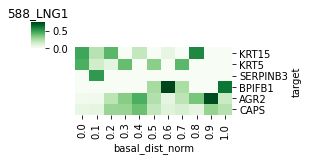

In [68]:
names=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
ggg=0
for el in gg:
    expp=el.transpose()
    genes=['KRT15','KRT5','SERPINB3','BPIFB1','AGR2','CAPS']
    expp=expp.loc[:,genes]
    expp=expp.div(expp.sum(axis=0),axis=1)
    expp=expp.div(expp.sum(axis=1),axis=0)
    sns.clustermap(expp.transpose(),row_cluster=False,col_cluster=False,cmap='Greens',figsize=(4,2))
   # expp.plot(kind='area',stacked=True,figsize=(5,2))
   # plt.legend(bbox_to_anchor=(1.5, 0.5),loc='right')
    plt.title(names[ggg])
    ggg=ggg+1

In [36]:
significantg=pvalsall.loc[list(np.sum(pvalsall.loc[:,['640_LNG2', '689_LNG2', '588_LNG2']]<0.001,axis=1)==3),['640_LNG2', '689_LNG2', '588_LNG2']]#.loc[,:]

In [37]:
significantg

640_LNG2       689_LNG2       588_LNG2
ADIRF      4.874908e-27   3.823585e-09   9.633310e-39
AGR2      1.881385e-112   9.656692e-46   1.690540e-64
APOC1      2.904345e-05   1.932247e-04   5.751730e-11
BPIFB1     4.260917e-62   0.000000e+00  1.713139e-207
CAPS       6.116880e-80   4.905973e-52  7.402773e-132
CCL5       8.056335e-04   9.689746e-09   3.113260e-18
CD24       7.576996e-69   1.359002e-33   6.592206e-66
CD3D       7.178936e-06   1.222795e-09   9.752561e-12
CDC20B     8.035941e-13  2.613856e-183   1.519727e-16
CLC        7.945591e-14   1.155086e-12   5.745305e-10
DDIT4      3.693253e-37  3.166754e-265   3.458451e-10
DNAH12     8.399681e-05   6.416926e-06   3.874763e-05
EGR1       1.562437e-37   3.811779e-58   1.220884e-04
EPCAM      2.554520e-09   5.655855e-04   1.266964e-04
FABP5      7.441400e-64  1.265117e-119   1.041837e-17
FCGR3B     4.038277e-54   2.856708e-05   3.068785e-04
FCN3       9.811358e-06   1.094671e-99   8.052461e-04
HLA-DRB1   8.488630e-08   9.586353e-05   1.767983e-07
HSPB1      5.811407e-38   1.485120e-55   1.309756e-12
IFI27      2.443980e-19   3.754095e-13   3.412975e-05
IFITM1    4.113717e-150   4.855416e-27  8.636628e-195
IFITM2     4.716002e-21   9.744297e-18   1.464348e-57
KLRD1      8.820507e-21   8.058526e-06   1.109186e-08
KRT15     1.792920e-182  2.316482e-181   3.457414e-43
KRT5       0.000000e+00   0.000000e+00  3.824543e-127
LYZ        4.349867e-40   3.297176e-04   2.461599e-65
MCEMP1     2.734696e-05   1.755219e-09   1.191468e-05
MSLN      2.178488e-116   1.494908e-93   6.953381e-11
MT2A       7.418071e-33   6.812932e-06   2.822590e-29
MUC5AC     1.159689e-09   4.149116e-24   2.649121e-29
PRR4       2.307360e-17   1.650287e-05   7.013684e-04
RHOB       3.035191e-50   5.481512e-23   4.354543e-14
S100A11    1.400357e-65   8.818480e-21   1.702789e-20
S100A2    2.495487e-271   4.233638e-48   7.438175e-30
S100A8    1.876002e-133   1.695937e-36   7.569725e-88
S100P     1.617480e-160   3.851390e-26   2.152005e-04
SAT1       2.760562e-56   1.113579e-30   1.071069e-17
SERPINB3   1.182258e-20   8.397777e-15   1.904524e-20
SLPI       0.000000e+00  1.281371e-137   1.861864e-41
SPRR3      5.884216e-38   1.048281e-73   2.206533e-05
WFDC2      1.302237e-23   1.865807e-19   1.679356e-15

In [80]:
comm=expsort_640C_LNG5.index[expsort_640C_LNG5.index.isin(expsort_640C_LNG3.index)]
comm2=expsort_640C_LNG2.index[expsort_640C_LNG2.index.isin(comm)]

In [81]:
# note that all the plots are normalized by size of the epithelium. Obviously, 
#the thinkness of LNG2 is way larger than LNG5

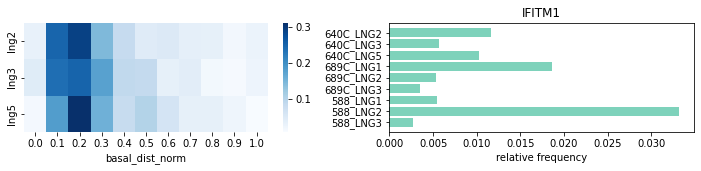

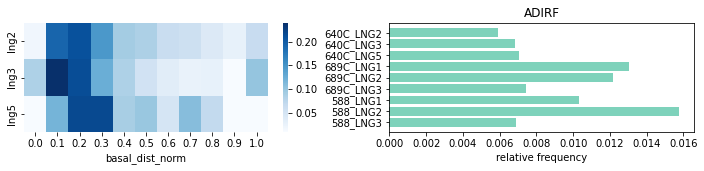

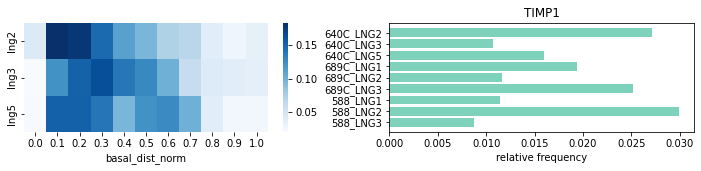

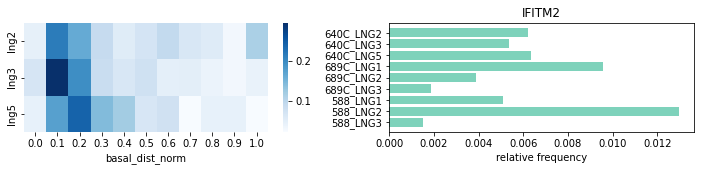

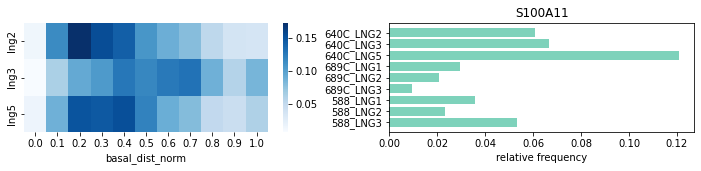

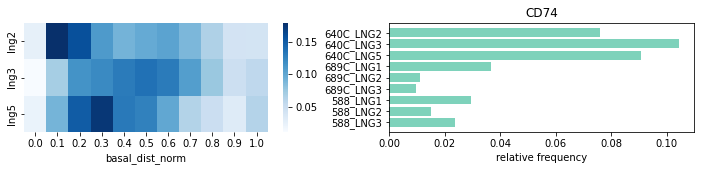

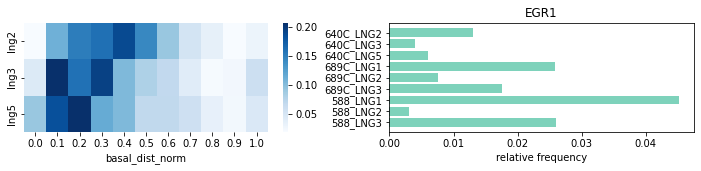

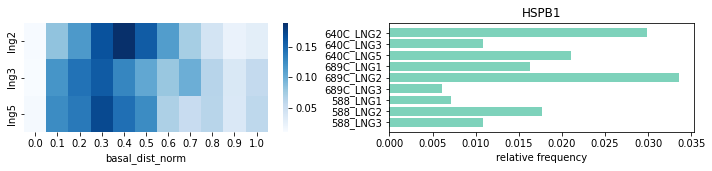

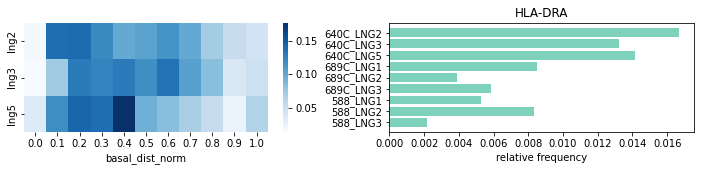

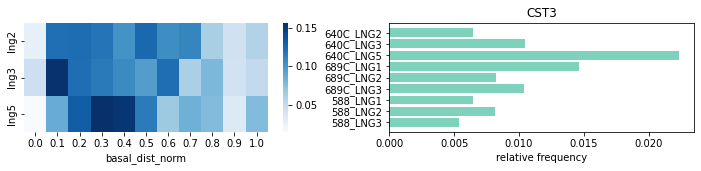

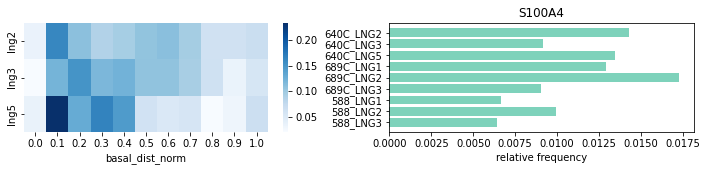

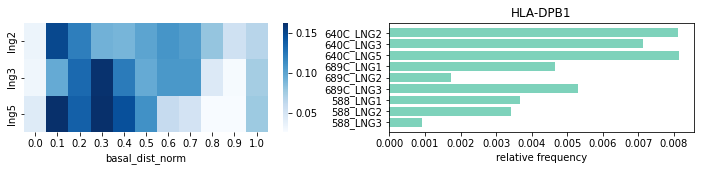

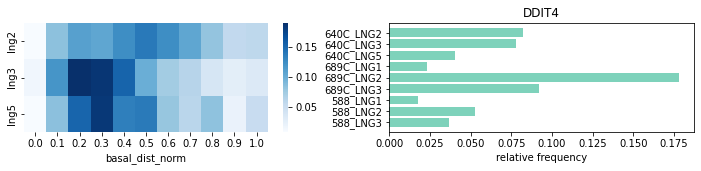

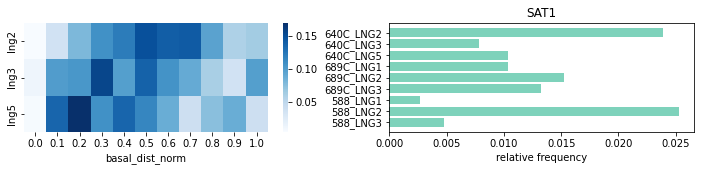

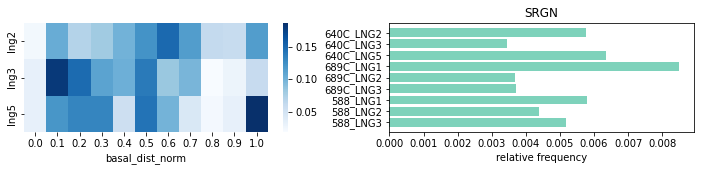

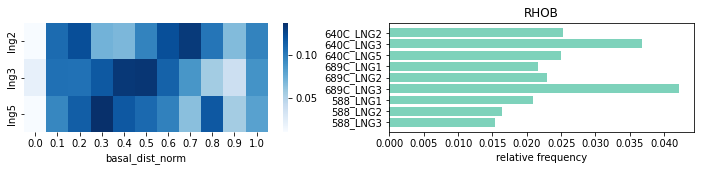

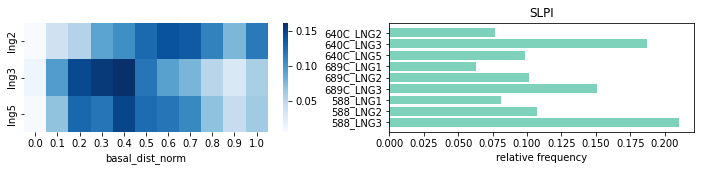

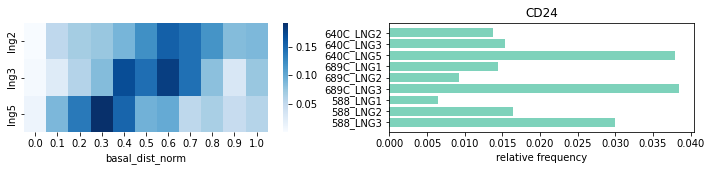

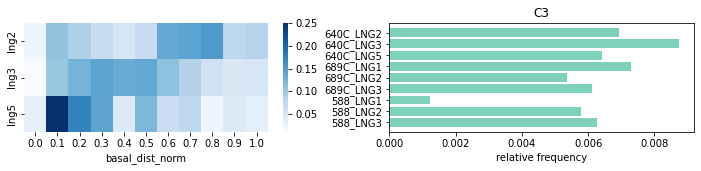

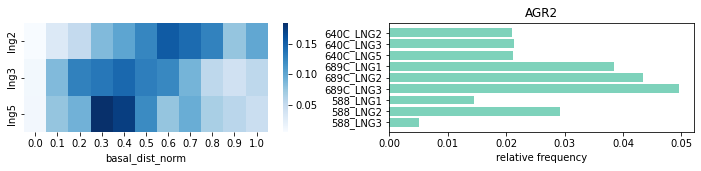

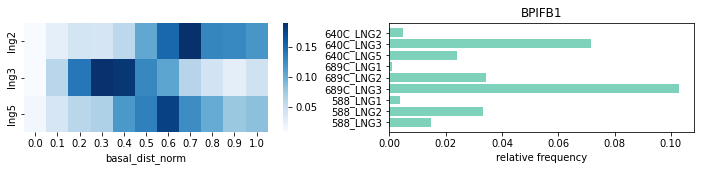

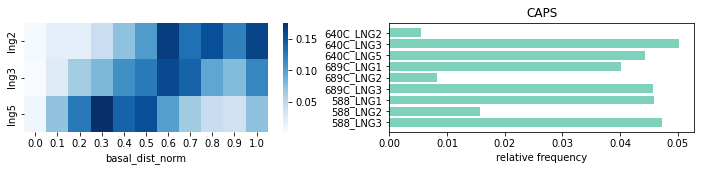

In [82]:

for g in comm2:
    lng5=expsort_640C_LNG5.loc[[g],:].transpose()
    lng2=expsort_640C_LNG2.loc[[g],:].transpose()
    lng3=expsort_640C_LNG3.loc[[g],:].transpose()
    locis=pd.concat([lng2,lng3,lng5],axis=1).fillna(0)
    locis.columns=['lng2','lng3','lng5']
    fig,axs=plt.subplots(1,2,figsize=(12,2))
    sns.heatmap(locis.transpose(),cmap='Blues',ax=axs[0])
    plt.title(g)
    plt.barh(exx.loc[g,::-1].index,exx.loc[g,::-1],color='#7ed2bb')
    plt.xlabel('relative frequency')
    plt.show()